# Deep Learning
## Summative assessment
### Coursework 1

#### Instructions

This coursework is released on **Tuesday 18th February 9.00** and is due by **Tuesday 11th March 9.00**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 50 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks shown per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for face verification. This is the problem of determining whether or not two images are of the same person.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

The data required for this assessment can also be downloaded from [this link](https://drive.google.com/file/d/1guvJwIdHKi4-AFRPs0v-6kfHZhEuo8x8/view?usp=sharing) in case you would prefer to work locally.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and PDF report.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook and separate PDF/HTML file(s) by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [43]:
# You will need the following imports for this assessment. You can make additional imports when you need them
import os
from functools import partial

from CW1.annoyed import get_simple_embedding_5_pooling_top, get_simple_embeddingV2_6_flat_top

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import matplotlib.pyplot as plt
import numpy as np

print(keras.backend.backend())


tensorflow


#### CASIA-Webface Dataset

This assessment makes use of the CASIA-Webface dataset, which is used for face verification and face identification tasks. The complete dataset consists of 494,414 face images of 10,575 real identities collected from the web. In this assessment, a smaller subset of the dataset has been prepared for you.

The dataset was first introduced in the following paper:

*  Yi, D., Lei, Z., Liao, S. and Li, S.Z. (2014), "Learning Face Representation from Scratch", arXiv preprint, abs/1411.7923.

The data subset is available for you in the folder `./data/casia-webface`.

 #### Contrastive learning

Your task in this assessment is to develop a deep learning model that can be used to verify if two images belong to the same person or not. The model will take an image as input, and output a fixed size embedding. The model will be trained such that different images belonging to the same identity should have embeddings that are close to each other (in some sense), and images belonging to different identities should have embeddings that are far apart.

The training algorithm you will use for this will be a form of contrastive learning. This is a learning paradigm where the objective function compares different examples in the dataset.

In particular, to train your model you will use a loss function that takes three examples: an anchor input $\mathbf{x}$, a positive example $\mathbf{x}^+$ that is similar to the anchor (the same identity), and a negative example $\mathbf{x}^-$ that is different to the anchor. The objective for the network is to embed the images such that the similarity between the anchor and positive example is maximised (or distance is minimised), and the similarity between the anchor and negative example is minimised (distance is maximised).

<center><img src="./figures/contrastive-learning.png" alt="Similarity of representations" style="width: 450px;"/></center>
<center>The model's objective is to minimize the distance (in embedding space) between an anchor and a positive example, both of which have the same identity, and maximize the distance between the anchor and a negative example of a different identity</center>
<br>

The loss function you will use is the circle loss, given by:

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],
$$
where $s_p$ (resp. $s_n$) is the positive (resp. negative) similarity score computed between the anchor and positive (resp. anchor and negative) examples, according to some choice of similarity measure in the embedding space. The hyperparameters $\alpha_p>0$ and $\alpha_n>0$ are example-specific weightings to emphasise either the positive or negative similarity scores in the gradient updates, and $\Delta_p>0$ and $\Delta_n>0$ are the positive and negative margins. 

The circle loss was introduced in the following paper:

* Sun, Y., Cheng, C., Zhang, Y., Zhang, C., Zheng, L. and Wang, Z. (2020), "Circle Loss: A Unified Perspective of Pair Similarity Optimization," *IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Seattle, WA, USA*, 6397-6406.

You will need to implement a custom data loading pipeline and custom training loop, as well as designing a dedicated model architecture that produces an embedding for a given input image. Details of the data loading and training procedures will be up to you to decide. You will process the data, train and evaluate the specified model, and then write a report to summarise the experiments and results.

The data processing, model design, training algorithm and evaluation will potentially require several hyperparameter choices, and you should experiment with different choices during the development of your model. In question 4 you will write a report detailing the experiments carried out. It is up to you which experiments you will run. It is not necessary to include all experiments carried out in code in this notebook - you only need to include the code for the final choice of hyperparameters (in order to avoid overly long notebook submissions).

### Question 1 (Total 8 marks)

a) In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. For example, it will be helpful to compute the number of distinct identities in the dataset, and visualise some of the images. You can also use comments and/or markdown as appropriate.

**(3 marks)**

### Solutions 1a. Initial Data Exploration

Tasks:

1. Find the number of directories in the ./data/casia-webface. This corresponds to the number of distinct faces.
2. Check how many photos we have on average per person. Is it the same for all people?
3. Load 9 photos. Inspect their dimensions and visualise them
4. Depending on how many photos there are, try to create a dataframe with one row per photo, having the dimensions and label of which person it belongs to?

In [44]:
# Number of directories
from pathlib import Path

root_path = Path('./data/casia-webface/')
dirs = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
# set(os.listdir(root_path)).difference(dirs) = .DS_Store
print(f'Number of directories/distinct faces: {len(dirs)}')

Number of directories/distinct faces: 8000


In [45]:
# Number of photos per person/statistics on number of photos
photos_per_person = np.array([len(os.listdir(os.path.join(root_path, d))) for d in dirs])
print(
    f'Average no of photos per person: {photos_per_person.mean():.0f}\nMax number of photos per person: {photos_per_person.min()}\nMin number of photos per person: {photos_per_person.max()}')

Average no of photos per person: 26
Max number of photos per person: 10
Min number of photos per person: 50


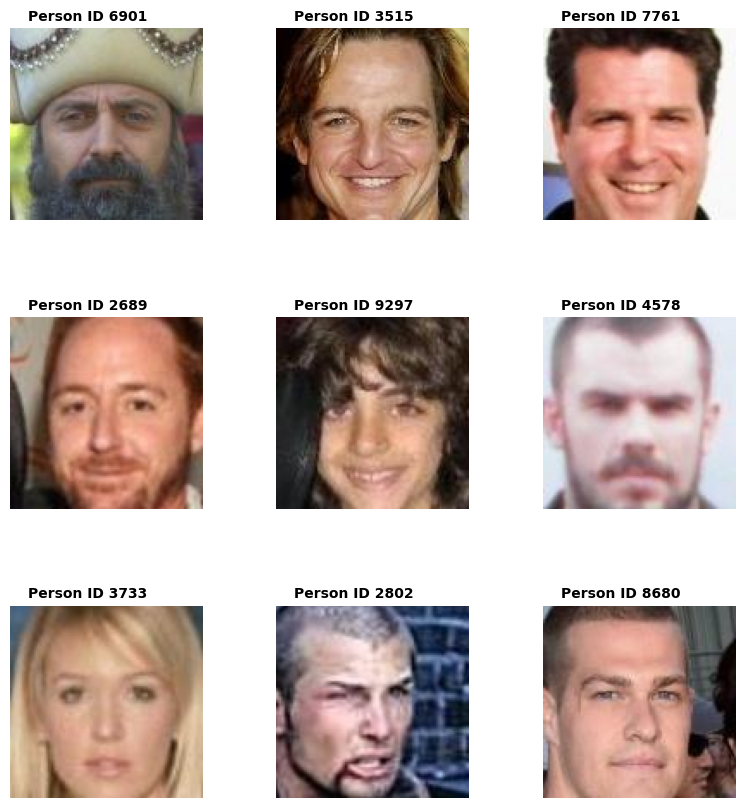

In [46]:
# Load 9 photos
# need to load the photos into a numpy array
all_photos = [os.path.join(root_path, d, p) for d in dirs for p in os.listdir(os.path.join(root_path, d))]
sample_photos = np.random.choice(all_photos, 9, replace=False)

n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for n, p in enumerate(sample_photos):
    row = n // n_cols
    col = n % n_cols
    photo = keras.utils.load_img(p)
    photo = keras.utils.img_to_array(photo, dtype='int32')
    axes[row, col].imshow(photo)
    axes[row, col].axis('off')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    person_id = p.rsplit('/', 2)[-2]
    axes[row, col].text(10., -5, f'Person ID {person_id}', fontsize=10, color='black', weight='bold')
plt.show()

In [47]:
def process_image(image_path) -> tuple:
    '''
    Helper function to get the details of each image in the dataset
    :param image_path: relative path of each image
    :return: tuple with person_id, photo_id, height, width, channels
    '''
    image = keras.utils.load_img(image_path)
    image = keras.utils.img_to_array(image, dtype='int32')
    person_id, photo_id = image_path.rsplit('/', 2)[-2:]
    if len(image.shape) == 2:
        return person_id, photo_id, image.shape[0], image.shape[1], 1
    return person_id, photo_id, image.shape[0], image.shape[1], image.shape[2]


import pandas as pd
from joblib import Parallel, delayed

results = Parallel(n_jobs=-1)(delayed(process_image)(p) for p in all_photos)
df = pd.DataFrame(results, columns=['person_id', 'photo_id', 'height', 'width', 'channels'])


In [48]:
# inspect whether all photos have the same dimensions (unlikely unless the dataset was pre-processed)
df[['height', 'width', 'channels']].describe()

,height,width,channels
count,211958.0,211958.0,211958.0
mean,112.0,112.0,3.0
std,0.0,0.0,0.0
min,112.0,112.0,3.0
25%,112.0,112.0,3.0
50%,112.0,112.0,3.0
75%,112.0,112.0,3.0
max,112.0,112.0,3.0


In [49]:
# Look at one of the photo arrays. Verify the pixel values range from 0 to 255
photo = keras.utils.load_img(all_photos[0])
photo = keras.utils.img_to_array(photo, dtype='int32')
print(photo[:2, :2, :])

[[[55 53 67]
  [55 53 67]]

 [[56 54 68]
  [56 54 68]]]


### Summary of Results

There are 8,000 distinct faces, with 10 to 50 photos per person and an average of 26 photos per person. The total number of photos is 211,958.
All photos have dimension 112x112x3 and the pixels range from 0 to 255 (RGB).

b) Create the dataset object(s) that you will use to train and evaluate your model. The only requirements for your datasets are as follows:

* You should use either TensorFlow Datasets or PyTorch Datasets/DataLoaders. 
* A number of identities should be selected, and for each identity a maximum number of images should be selected.
* The dataset should return an aligned pair of Tensors `(identities, images)` with shapes `(N,)` and `(N, height, width, channels)`, where `N` is the total number of images selected across all selected identities.

You can use any tools from Keras, TensorFlow or PyTorch that might be useful for this task.

Demonstrate that your dataset creation and processing is working as intended.

**(5 marks)**

### Solutions 1b. Dataset Creation

* Use `torch` (better performance on Apple Silicon).
* Write a helper function called `load_images` which returns the labels and images as Tensors.
    * Use `torchvision` to apply transformations to the images
    * Allow for additional image transformations (might be useful to use data augmentation later)
* Write a function called `get_dataloader` which returns the dataloader for the dataset. This should take the same parameters as the helper function plus the batch size and shuffle option.

Function parameters: the path, number of people (fixed), max number of photos per person, additional transforms.


In [50]:
# Torch DataLoaders appear to be slightly
from PIL import Image
import torch
from torchvision import transforms
from typing import Optional, Tuple


def load_images(root_path: str, max_photos_per_person: int = 50, no_people: int = 1000,
                img_transforms: Optional[list] = None, seed: int = 42) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Helper function for loading and creating the dataloaders
    :param root_path: path to the dataset
    :param max_photos_per_person: maximum number of photos per person (max possible is 10)
    :param no_people: number of distinct identities (max possible is 8000)
    :param img_transforms: optional image transformations, in a list format. Need to be compatible with torchvision.transforms
    (torch.nn.Module) and should operate on an image tensor (not a PIL array)
    :param seed: random seed for reproducibility
    :return: tuple of labels and images
    '''
    np.random.seed(seed)
    all_people = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    selected_people = np.random.choice(all_people, min(no_people, len(all_people)), replace=False)

    img_transforms_ = [transforms.ToTensor(),  # -> torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
                       transforms.ConvertImageDtype(torch.float32)]
    img_transforms_.extend(img_transforms or [])
    img_transforms_ = transforms.Compose(img_transforms_)

    img_list = []
    label_list = []
    for label_id, person in enumerate(selected_people):
        person_path = os.path.join(root_path, person)
        all_files = os.listdir(person_path)
        selected_files = all_files[:max_photos_per_person]
        for f in selected_files:
            img_path = os.path.join(person_path, f)
            img = Image.open(img_path)  # already in RGB here.
            img_tensor = img_transforms_(img)
            img_list.append(img_tensor)
            label_list.append(label_id)

    img_tensor = torch.stack(img_list, dim=0)  # shape N, C, H, W
    img_tensor = img_tensor.permute(0, 2, 3, 1)
    label_tensor = torch.from_numpy(np.array(label_list).astype(np.int32).reshape(-1))
    return label_tensor, img_tensor


labels, images = load_images(root_path=root_path, max_photos_per_person=2, no_people=3, img_transforms=None)
print(labels)  # expected [0, 0, 1, 1, 2, 2]
print(images.shape)  # expected (6, 112, 112, 3)

tensor([0, 0, 1, 1, 2, 2], dtype=torch.int32)
torch.Size([6, 112, 112, 3])


In [51]:
def get_dataloader(root_path: str, batch_size: int, shuffle: bool, max_photos_per_person: int = 50,
                   no_people: int = 1000, img_transforms: Optional[list] = None,
                   seed: int = 42) -> torch.utils.data.DataLoader:
    '''
    Function to get the dataloader for the dataset
    
    :param root_path: path to the dataset
    :param batch_size: batch size for the dataloader
    :param shuffle: whether to shuffle the dataset
    :param max_photos_per_person: maximum number of photos per person (max is 10)
    :param no_people: maximum number of people (max is 8000)
    :param img_transforms: optional image transformations, in a list format. Need to be compatible with torchvision.transforms
    (torch.nn.Module) and should operate on an image tensor (not a PIL array)
    :param seed: random seed for reproducibility
    :return: dataloader for the dataset
    '''
    labels, images = load_images(root_path, max_photos_per_person, no_people, img_transforms, seed)
    dataset = torch.utils.data.TensorDataset(labels, images)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [52]:
dataloader_test = get_dataloader(root_path, batch_size=2, shuffle=True, max_photos_per_person=2, no_people=3,
                                 img_transforms=None)

# Check that shuffle gets us all permutations of batches and validate the sizes and shapes
# Expected: 2 batches of 2 images each
for i, (l, p) in enumerate(dataloader_test):
    print(f'Batch {i}:\nLabels: {l}\nPhotos: {p.shape}')


Batch 0:
Labels: tensor([1, 2], dtype=torch.int32)
Photos: torch.Size([2, 112, 112, 3])
Batch 1:
Labels: tensor([1, 0], dtype=torch.int32)
Photos: torch.Size([2, 112, 112, 3])
Batch 2:
Labels: tensor([0, 2], dtype=torch.int32)
Photos: torch.Size([2, 112, 112, 3])


In [53]:
# Try an additional transform:
from torchvision.transforms import v2

img_transforms = [v2.RandomAdjustSharpness(sharpness_factor=10, p=1)]

original = get_dataloader(root_path, batch_size=1, shuffle=False, max_photos_per_person=1, no_people=1)
sharpened = get_dataloader(root_path, batch_size=1, shuffle=False, max_photos_per_person=1, no_people=1,
                           img_transforms=img_transforms)

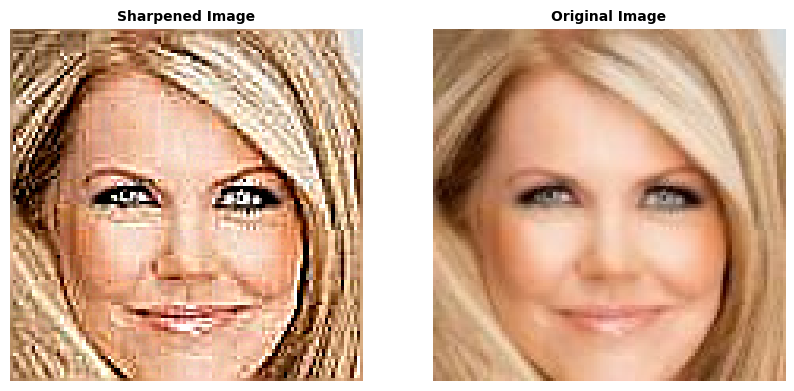

In [54]:
# Visualise the sharpened image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sharpened.dataset.tensors[1][0].detach().numpy())
axes[0].axis('off')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].set_title('Sharpened Image', fontsize=10, color='black', weight='bold')
axes[1].imshow(original.dataset.tensors[1][0].detach().numpy())
axes[1].axis('off')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].set_title('Original Image', fontsize=10, color='black', weight='bold')

plt.show()

#### Version 2 (Used Later)

Although we believe the question expects the above implementation, we chose to implement a custom `Dataset` class that we will use for our training.

**`ImageDataset` specifications:**
* The constructor takes the following arguments: `no_photos`, `img_transforms` (optional), `augment` . If `img_transforms` is not provided, the default option is used. The `augment` argument is a boolean flag that indicates whether to apply the `img_transforms` to the images. This allows us to get a richer training dataset. For testing this should be `False`.
* The `__len__` method returns the number of identities available
* The `__getitem__` method takes an index and returns a tuple of tensors corresponding to (identities, images) with shapes (K,), (K, height, width, channels) where K = `no_photos`
* If there are fewer than `no_photos` images for a given identity, additional photos are generated using the `img_transforms`.

**`Dataloader` specifications:**

The new `get_dataloader` method does not take a batch size, instead it computes it using the number of people and number of photos requested.


In [55]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, no_photos, augment: bool = False, test: bool = False):
        '''
         Custom dataset class to sample an identity and return no_photos of that identity

        :param no_photos: Integer, the number of images to return per sample
        :param augment: Whether the images should be transformed. Note that at test time any transforms should be deterministic
        :para test: If test is False, the identities are selected from the first 1768 (=8000-32) of the
         identities, and they are shuffled before being drawn. If true then the last 32 identities are used
        '''
        self.root_dir = Path('./data/casia-webface/')
        self.no_photos = no_photos
        augment_transforms = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomResizedCrop((112, 112), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            transforms.RandomGrayscale(p=0.1),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # need to write another function to un-normalise in order to visualise.
        ])
        self.image_generating_transforms = augment_transforms
        self.default_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                                      transforms.CenterCrop((112, 112)),
                                                      transforms.ToTensor(),
                                                      # -> torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
                                                      transforms.ConvertImageDtype(torch.float32)])
        self.augment_transforms = augment_transforms if augment else self.default_transforms
        self.augment = augment
        self.__set_labels(test=test)

    def __set_labels(self, test: bool):
        labels = sorted([x for x in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, x))])
        if test:
            self.labels = labels[-32:]
        else:
            labels = labels[:-32]
            np.random.shuffle(labels)
            self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        identity = self.labels[idx]
        img_paths = [os.path.join(self.root_dir, identity, x) for x in
                     os.listdir(os.path.join(self.root_dir, identity))]

        if len(img_paths) >= self.no_photos:
            img_paths = np.random.choice(img_paths, size=self.no_photos, replace=False)
            extra = 0
        else:
            extra = self.no_photos - len(img_paths)

        img_list = []
        for img_path in img_paths:
            img = Image.open(img_path)  # already in RGB here.
            img_tensor = self.augment_transforms(img)
            img_list.append(img_tensor)

        if extra:
            for i in range(extra):
                img_path = np.random.choice(img_paths)
                img = Image.open(img_path)
                img_tensor = self.image_generating_transforms(img)
                img_list.append(img_tensor)

        img_tensor = torch.stack(img_list, dim=0)  # shape N, C, H, W
        img_tensor = img_tensor.permute(0, 2, 3, 1)
        label_tensor = torch.from_numpy(np.repeat(idx, self.no_photos).astype(np.int32))
        return label_tensor, img_tensor

def collate_fn(batch):
    '''
    Our dataloader returns samples of shape (no_images, H, W, C) which means the data loader returns batches of shape (batch_size, no_images, H, W, C) 
    by default. This collate function stacks the datasets together.
    
    :param batch: tuple of torch tensors of shapes (no_people, no_images) and (no_people, no_images, H, W, C)
    :return: tuple of torch tensors of shape (no_people x no_images, ) and (no_people x no_images, H, W, C)
    '''
    labels, images = zip(*batch)
    labels = torch.cat(labels, dim=0)
    images = torch.cat(images, dim=0)
    return labels, images


# overwrite the previous method - not clean code but this is a notebook so ...
def get_dataloader(no_people: int = 32, no_photos: int = 4, img_transforms: Optional[list] = None,
                   shuffle: bool = False, augment: bool = False, collate_fn=collate_fn, **kwargs):
    '''
    Function to get the dataloader for the dataset

    :param no_people: Number of people to sample
    :param no_photos: Number of photos to return per person
    :param img_transforms: an optional list of transformations to be applied to the image (after it is converted to a tensor so ensure compatibility)
    :param shuffle: If true, samples are shuffled
    :param augment: If True the images are augmented
    :param collate_fn: Collate function. This is used to transform the shape of the batch. By default, given our dataset, the batches would consist of a 2d tuple with dimensions:
        (no_people, no_photos) <-- labels
        (no_people, no_photos, 112, 112, 3) <-- images
    both are fine since we are anyway writing a custom training loop, but we added the collate function to be in line with the exercise
    :return: the dataloader to be used for training the model
    '''
    dataset = ImageDataset(no_photos=no_photos, augment=augment, test=not shuffle)
    return torch.utils.data.DataLoader(dataset, batch_size=no_people, shuffle=shuffle, drop_last=True,
                                       collate_fn=collate_fn, **kwargs)

In [56]:
dataloader_train = get_dataloader(augment=False, shuffle=True)
# expected length is int(7968 identities / 32 identities per batch) = 249
print(len(dataloader_train))

batch = next(iter(dataloader_train))
labels, images = batch
# expected a set of 32 distinct labels/identities
print(len(set(labels.numpy())))

# expected (128,) (128, 112, 112, 3)
print(labels.shape)
print(images.shape)

249
32
torch.Size([128])
torch.Size([128, 112, 112, 3])


In [57]:
dataloader_test = get_dataloader(augment=False, shuffle=False)
# expected length is int(32 identities / 32 identities per batch) = 1
print(len(dataloader_test))

batch = next(iter(dataloader_test))
labels, images = batch
# expected a set of 32 distinct labels/identities
print(len(set(labels.numpy())))

# expected (128,) (128, 112, 112, 3)
print(labels.shape)
print(images.shape)

1
32
torch.Size([128])
torch.Size([128, 112, 112, 3])


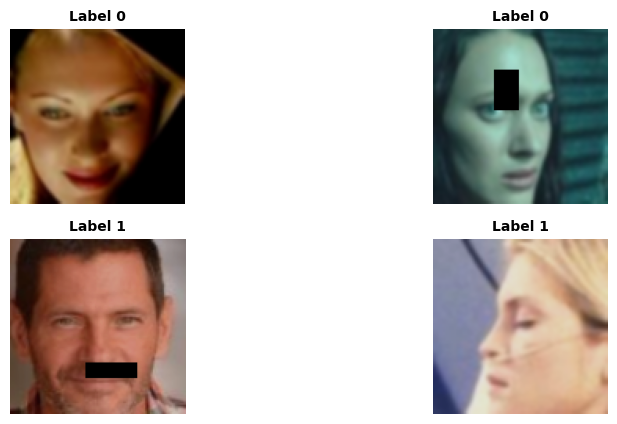

In [58]:
sample_data = get_dataloader(no_people=2, no_photos=2, shuffle=True, augment=True)
labels, images = next(iter(sample_data))

images = images.flatten().reshape(2, 2, 112, 112, 3)
# Visualise the sharpened image
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(images[i, j, ...].detach().numpy())
        axes[i, j].axis('off')
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        axes[i, j].set_title(f'Label {i}', fontsize=10, color='black', weight='bold')

plt.show()

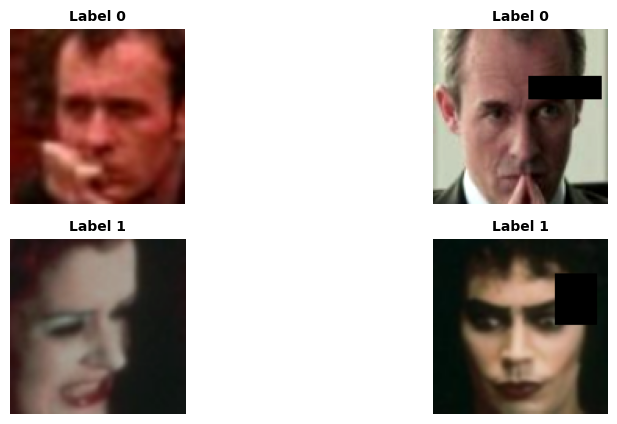

In [59]:
# Repeat to check if Dataloader shuffles or if they are always in the same order. If they are always in the same order, the same people will be appearing together
# It is OK - if shuffle = True they get shuffled otherwise it's the same images

sample_data = get_dataloader(no_people=2, no_photos=2, shuffle=True, augment=True)
labels, images = next(iter(sample_data))
images = images.flatten().reshape(2, 2, 112, 112, 3)
# Visualise the sharpened image
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(images[i, j, ...].detach().numpy())
        axes[i, j].axis('off')
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        axes[i, j].set_title(f'Label {i}', fontsize=10, color='black', weight='bold')

plt.show()


### Question 2 (Total 20 marks)

a) Recall the circle loss is given by

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],\tag{1}
$$

where $\alpha_p>0$, $\alpha_n>0$, $\Delta_p>0$ and $\Delta_n>0$ are hyperparameters, and $s_p$ and $s_n$ are the similarity scores between anchor-positive and anchor-negative pairs according to some similarity measure.

The [triplet loss](https://en.wikipedia.org/wiki/Triplet_loss) is a similar loss function for contrastive learning that was developed a few years earlier. It is given by:

$$
\mathcal{L}_{\textrm{triplet}}(\mathbf{x}, \mathbf{x}^+, \mathbf{x}^-) =  \max(0, || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2  + m)\tag{2}
$$

where $f_\theta$ is a network that maps images to a fixed-size embedding, $\mathbf{x}$ is an anchor example, $\mathbf{x}^+$ is a corresponding positive example, and $\mathbf{x}^-$ is a negative example, and $m>0$ is a hyperparameter that sets the minimum offset between distances of similar vs dissimilar pairs. 

Show that the triplet loss can be derived from the circle loss as a certain limit, with a certain choice of hyperparameters $\alpha_p$, $\alpha_n$, $\Delta_p$ and $\Delta_n$ and similarity measure.

**(2 marks)**

### Solutions 2a. Triplet Loss Derivation

We begin by noting that
$$
\lim_{\gamma \to \infty} \frac{1}{\gamma}\log(1 + \exp(\gamma x)) = \max(0, x).
$$


_Proof_


If $x<0$,
$$
\lim_{\gamma \to \infty} \frac{1}{\gamma} \log(1 + \exp(-\gamma |x|)) = 0
$$
and if $x > 0$,
$$
\lim_{\gamma \to \infty} \frac{1}{\gamma} \log(1 + \exp(\gamma x)) \approx \lim_{\gamma \to \infty} \frac{1}{\gamma}\log (\exp(\gamma x)) = \lim_{\gamma \to \infty} x = x.
$$

Next, we choose the similarity score to be the negative squared Euclidean distance between the embedded images which means that the smaller the distance between two embeddings, the larger the similarity score. We can write the similarity scores as
$$
\begin{array}{l}
s_p = -||f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)||_2^2 \\
s_n = -||f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)||_2^2
\end{array}
$$
Inspecting the triplet loss, we can see that the coefficients of the squared distances are equal to 1, hence we need to choose $\alpha_p = \alpha_n = 1$.
Finally, by $\Delta_p - \Delta_n = m$, the circle loss reduces to the triplet loss.

To summarise, in the limit $\gamma \to \infty$ (hard mining), and for $\alpha_n = \alpha_p = 1$, $\Delta_p - \Delta_n = m$ (reduction in the number of hyperparameters), the circle loss reduces to the triplet loss if we choose the similarity metric to be the negative square distance between the embeddings.

b) You will use the circle loss to train your model. Following Sun et al., we will assume that the similarity score takes values between 0 and 1. A suitable choice of similarity measure that satisfies this is the scaled cosine similarity $s(\mathbf{x}_1, \mathbf{x}_2) = (\langle \mathbf{x}_1, \mathbf{x}_2 \rangle + 1) / 2$, where $\mathbf{x}_1$ and $\mathbf{x}_2$ have been normalised such that $||\mathbf{x}_1||_2 = ||\mathbf{x}_2||_2 = 1$.

With this choice, typical settings for the hyperparameters in the circle loss are

$$
\begin{align}
\alpha_p &= 1 + m - s_p\\
\alpha_n &= s_n + m\\
\Delta_p &= 1 - m\\
\Delta_n &= m
\end{align}
$$

where $0<m<1$ is the _margin_. These settings reduce the hyperparameters in the loss function to just one (the margin $m$).

Write a function `circle_loss` to implement the circle loss as described above. Your loss function implementation should therefore take the following arguments:

* `anchor_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the anchor images
* `positive_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the corresponding positive images
* `negative_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised  model embeddings for the corresponding negative images
* `m`, a float value between zero and 1: the margin
* `gamma`, a positive float: scaling hyperparameter in the circle loss

**(2 marks)**

### Solutions 2b. Implementation of Circle Loss

* Write a function called `circle_loss` to compute circle loss:
$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],
$$ where all parameters are given in terms of the similarity scores, $m$ and $\gamma$, as defined above.


In [60]:
def scaled_cosine_similarity(a, b):
    '''
    Computes the scaled cosine similarity between two 1-d or 2-d tensors,  row-wise
    Args:
        a: L2 normalised tensor or shape (d,) or (N, d)
        b: L2 normalised tensor of shape (d,) or (N, d)

    Returns: Tensor of shape (N,) containing scaled cosine similarities between each pair.
    '''
    cos_sim = keras.ops.sum(a * b, axis=-1)
    return (cos_sim + 1) / 2


def circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings,
                m=0.2, gamma=256):
    '''
    Computes the Circle Loss as described in the assignment, using Keras ops.

    :param anchor_embeddings: Tensor of shape (N, d), l2-normalised embeddings for anchor images.
    :param positive_embeddings: Tensor of shape (N, d), l2-normalised embeddings for positive images.
    :param negative_embeddings: Tensor of shape (N, d), l2-normalised embeddings for negative images.
    :param m: Margin parameter, typically between 0 and 1.
    :param gamma: Scaling hyperparameter in the circle loss.
    :return: Scalar tensor representing the mean circle loss over the batch.
    '''
    anchor_embeddings = keras.ops.normalize(anchor_embeddings, axis=-1)
    positive_embeddings = keras.ops.normalize(positive_embeddings, axis=-1)
    negative_embeddings = keras.ops.normalize(negative_embeddings, axis=-1)

    # Similarities (scaled cosine similarity between corresponding rows)
    sp = scaled_cosine_similarity(anchor_embeddings, positive_embeddings)
    sn = scaled_cosine_similarity(anchor_embeddings, negative_embeddings)

    # Compute alpha and delta terms
    alpha_p = keras.ops.relu(1 + m - sp)  # ensures min=0
    alpha_n = keras.ops.relu(sn + m)
    delta_p = 1 - m
    delta_n = m

    logit_p = - alpha_p * (sp - delta_p)
    logit_n = alpha_n * (sn - delta_n)
    logits = logit_p + logit_n
    loss = (1.0 / gamma) * keras.ops.softplus(logits * gamma)
    # Return the mean loss over the batch
    return keras.ops.mean(loss)


In [61]:
# test the loss function using 3 random (normalised) tensors of shapes (10, 128)
anchor = torch.nn.functional.normalize(torch.randn(10, 128), dim=1)
positive = torch.nn.functional.normalize(torch.randn(10, 128), dim=1)
negative = torch.nn.functional.normalize(torch.randn(10, 128), dim=1)
print(circle_loss(anchor, positive, negative, m=0.25, gamma=256))


tf.Tensor(0.38047463, shape=(), dtype=float32)


c) You should design and implement a model that will be trained on the face verification task, using the circle loss defined above. 

The only specifications for your model is that it should take a batch of images as input, and return a batch of embeddings as output. Each embedding will be a fixed-size vector in $\mathbb{R}^d$ (and you are also free to choose $d$). The embeddings should be normalised to have unit $\ell_2$ norm.

Your model should be defined entirely using Keras. Print the model summary to show details of your chosen design.

**(3 marks)**

### Solutions 2c. Model Design

For this question we implemented and tested a large number of models. Of these models we present the following:

1. An implementation from scratch of an adaptaption of the `EfficientNetB0` architecture described in the paper "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks" by Tan and Le (2019) [1]
2. A `SimpleEmbeddingNet` consisting of a number (4) convolutional blocks with each block doubling the filters and reducing the height and width dimensions using **pooling**.
3. A `SimpleEmbeddingNetV2` which, similarly to `SimpleEmbeddingNet` consists of a number of convolutional blocks which double the filters and reduce the height and width dimensions but now the reduction is done using a higher stride instead of pooling.

The first model was chosen because it is considered a good benchmark model and it allowed us to learn more complex architectures. It also has a pre-trained model within keras which we could fine tune/retrain to learn the embeddings.

The designs of the two simple embedding nets were motivated by the fact that we are trying to reduce the dimensionality of the images from (112x112x3) to the embedding dimensions. Hence, it made sense to use a sequence of convolutions to distill the information in the original image to smaller representations.
We chose two standard ways to perform the dimensionality reduction, pooling and tuning the shape of the convolutions.

Below we present each model separately.

[1] Tan, M. &amp; Le, Q.. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. <i>Proceedings of the 36th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 97:6105-6114 Available from https://proceedings.mlr.press/v97/tan19a.html.


##### Model 1: `EfficientNet`
We begin by presenting `EfficientNet` which was inspired by the architecture in [1]. The choice of this model was motivated by its performance and relatively small size (approximately 4.5 million trainable parameters).

The original `EfficientNet` uses compound scaling to compute the depth (d), width (w) and resolution (r) of the model. Our inputs have half the resolution of the original `EfficientNetB0` model, but we nonetheless did not change the depth and width of the model.

The table below provides a summary of our model.

| Stage | Operator              | Kernel | Stride | In Channels | Out Channels | In Resolution | Out Resolution       | Layers |
|-------|-----------------------|--------|--------|-------------|--------------|---------------|----------------------|--------|
| 1     | Conv2d                | 3x3    | 2      | 3           | 32           | 112x112       | 56x56                | 1      |
| 2     | MBConv                | 3x3    | 1      | 32          | 16           | 56x56         | 56x56                | 1      |
| 3     | MBConv                | 3x3    | 2      | 16          | 24           | 56x56         | 28x28                | 2      |
| 4     | MBConv                | 5x5    | 2      | 24          | 40           | 28x28         | 14x14                | 2      |
| 5     | MBConv                | 3x3    | 2      | 40          | 80           | 14x14         | 7x7                  | 3      |
| 6     | MBConv                | 5x5    | 1      | 80          | 112          | 7x7           | 3x3                  | 3      |
| 7     | MBConv                | 5x5    | 2      | 112         | 192          | 3x3           | 1x1                  | 4      |
| 8     | MBConv                | 5x5    | 1      | 192         | 320          | 1x1           | 1x1                  | 1      |
| 9     | Conv2d                | 1x1    | 1      | 320         | 1280         | 1x1           | 1x1                  | 1      |
| 10    | Dropout               | -      | -      | 1280        | 1280         | 1x1           | 1x1                  | 1      |
| 11    | Flatten               | -      | -      | 1280        | 1280         | 1x1           | Vector (1280)        | 1      |
| 12    | Fully Connected Layer | -      | -      | 1280        | 128          | Vector (1280) | Vector (128=Emb.Dim) | 1      |
| 13    | L2 Norm               | -      | -      | 128         | 128          | Vector (128)  | Vector (128=Emb.Dim) | 1      |

Every convolutional layer is followed by a batch normalisation and activation (unless otherwise specified). By default, the activation used is `swish`, in line with `EfficientNet`.

The `MBConv` is a mobile inverted bottleneck block [2] with squeeze-and-excitation (SE) optimization.
This is a block consisting of a number of inverted residual blocks, which are a type of residual block that uses depthwise separable convolutions. In the above, the `#Layers` column indicates how many blocks are used in that stage. This is relevant for the `MBConv` blocks as it indicates how many inverted residual blocks are stacked together.

Below we implemented two functions that return the `InvResNet` and `MBConv` as keras models. The choice to return keras models (instead of implementing these as custom layers) was made because it was the only clean way that allowed us to print the full model summary.

The **InvResNet** blocks are the main building blocks of the model. Each block consists of the following steps:
1. 1x1 convolution (expansion)
2. Depth-wise separable convolution
3. Squeeze and Excite. Compute the weights as follows:
* Global average pooling (reduce spatial dims to channels)
* 1x1 convolution (reduce channels) (no batch norm and activation)
* 1x1 convolution (restore channels) (no batch norm and activation)
 and finally scale original feature map by multiplying with the weights
4. 1x1 convolution (projection)
5. Add skip connection where relevant

The `MBConv` layers stack together a number of `InvResNet`, as specified by `#Layers` above.

For the top which handles the vector embedding, we tried two architectures. The first relied on global average pooling to flatten the vector and the second uses a flatten layer. In all our experiments we found a better performance with a flatten layer and then a fully connected layer versus a pooling layer followed by the fully connected layer. Here we present only the flatten version.

Summaries of the different components of the architecture are provided below.

[1] Tan, M. &amp; Le, Q.. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. <i>Proceedings of the 36th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 97:6105-6114 Available from https://proceedings.mlr.press/v97/tan19a.html.

[2] M. Sandler, A. Howard, M. Zhu, A. Zhmoginov and L. -C. Chen, "MobileNetV2: Inverted Residuals and Linear Bottlenecks," 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, Salt Lake City, UT, USA, 2018, pp. 4510-4520, doi: 10.1109/CVPR.2018.00474. keywords: {Manifolds;Neural networks;Computer architecture;Standards;Computational modeling;Task analysis},



In [62]:
ACTIVATION = 'relu6'


def padding(inputs, kernel_size):  # copied from EfficientNet because mine was getting the number wrong.
    """Returns a tuple for zero-padding for 2D convolution with downsampling.

    Args:
      inputs: Input tensor.
      kernel_size: An integer or tuple/list of 2 integers.

    Returns:
      A tuple.
    """
    img_dim = 1
    input_size = inputs.shape[img_dim: (img_dim + 2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return (
        (correct[0] - adjust[0], correct[0]),
        (correct[1] - adjust[1], correct[1]),
    )


def InvResBlock(activation=ACTIVATION, drop_rate=0.0, name='', filters_in=32, filters_out=16, kernel_size=3,
                strides=1, expand_ratio=1, se_ratio=0.0):
    '''
    Builds an inverted residual block with optional squeeze-and-excitation.

    :param activation: Activation function to use, e.g., 'relu', 'swish'. Default is ACTIVATION.
    :param drop_rate: Dropout rate for the dropout layer. Default is 0.0.
    :param name: Name prefix for the block. Default is an empty string.
    :param filters_in: Number of input filters (channels). Default is 32.
    :param filters_out: Number of output filters (channels). Default is 16.
    :param kernel_size: Size of the convolution kernel. Default is 3.
    :param strides: Stride of the convolution. Default is 1.
    :param expand_ratio: Expansion ratio for the block. Default is 1. (Must be INTEGER!!)
    :param se_ratio: Squeeze-and-excitation ratio. Default is 0.0.

    :return: A model that represents the inverted residual block. Chose this implemenation to be able to view
    the model summary in detail.
    '''
    name = f'{name.strip("_")}_' if name else ''

    inputs = keras.layers.Input(shape=(None, None, filters_in), name=f'{name}input')

    # Track current tensor
    x = inputs

    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = keras.layers.Conv2D(filters, kernel_size=1, padding='same', use_bias=False,
                                kernel_initializer=keras.initializers.VarianceScaling(scale=2.0),
                                name=f'{name}expansion_Conv2D')(x)
        x = keras.layers.BatchNormalization(name=f'{name}expansion_BN')(x)
        x = keras.layers.Activation(activation, name=f'{name}expand_activation')(x)

    # Depthwise Convolution
    if strides == 2:
        # manually add padding because we want the output dim to be the same and padding = same with stride = 2 would halve the output dim
        x = keras.layers.ZeroPadding2D(padding=padding(x, kernel_size), name=f'{name}DWConv_zeropadding')(x)
        conv_pad = 'valid'
    else:
        conv_pad = 'same'
    x = keras.layers.DepthwiseConv2D(kernel_size, strides=strides, padding=conv_pad, use_bias=False,
                                     depthwise_initializer=keras.initializers.VarianceScaling(scale=2.0),
                                     name=f'{name}DWConv')(x)
    x = keras.layers.BatchNormalization(name=f'{name}DWConv_BN')(x)
    x = keras.layers.Activation(activation, name=f'{name}DWConv_activation')(x)

    # Squeeze and Excitation phase
    if 0 < se_ratio <= 1:
        filters_se = max(1, int(filters_in * se_ratio))
        se = keras.layers.GlobalAveragePooling2D(name=f'{name}SE_squeeze')(x)
        se = keras.layers.Reshape((1, 1, filters), name=f'{name}SE_reshape')(se)
        se = keras.layers.Conv2D(filters_se, kernel_size=1, padding='same', activation=activation,
                                 kernel_initializer=keras.initializers.VarianceScaling(scale=2.0),
                                 name=f'{name}SE_reduce')(se)
        se = keras.layers.Conv2D(filters, kernel_size=1, padding='same', activation='sigmoid',
                                 kernel_initializer=keras.initializers.VarianceScaling(scale=2.0),
                                 name=f'{name}SE_expand')(se)
        x = keras.layers.multiply([x, se], name=f'{name}SE_excite')

    # Projection phase
    x = keras.layers.Conv2D(filters_out, kernel_size=1, padding='same', use_bias=False,
                            kernel_initializer=keras.initializers.VarianceScaling(scale=2.0),
                            name=f'{name}project_conv')(x)
    x = keras.layers.BatchNormalization(name=f'{name}project_BN')(x)

    # Add skip connection
    if strides == 1 and filters_in == filters_out:
        if drop_rate > 0:
            x = keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1, 1), name=f'{name}drop')(x)
        x = keras.layers.add([x, inputs], name=f'{name}add')
    return keras.models.Model(inputs, x, name=name.strip('_'))


def MBConv(filters_in=3, filters_out=16, expand_ratio=1.0, kernel_size=3, strides=1, drop_rate=0.0, starting_block=0,
           se_ratio=0.0, activation='swish', name='', num_blocks=1):
    '''
    Builds a mobile inverted residual block with multiple inverted residual blocks.

    :param filters_in: Number of input channels.
    :param filters_out: Number of output channels after each block.
    :param expand_ratio: Expansion factor for the block.
    :param kernel_size: Size of the convolution kernel.
    :param strides: Stride of the convolution.
    :param drop_rate: Drop rate factor (for each block, the actual drop rate is computed dynamically.
                      Deeper layers have higher drop rates).
    :param starting_block: The current inverted residual block number (used to compute the drop rate).
    :param se_ratio: Squeeze-and-excitation ratio. Default is 0.0.
    :param activation: Activation function to use. Default is 'swish' but light model uses 'relu6'.
    :param name: Name for the block.
    :param num_blocks: Number of inverted residual blocks to stack.
    :return: A Keras Model representing the mobile inverted residual block.
    '''
    name = f'{name.strip("_")}_' if name else ''

    inputs = keras.layers.Input(shape=(None, None, filters_in), name=f'{name}input')

    # Track current tensor
    x = inputs
    for i in range(num_blocks):
        block_strides = strides if i == 0 else 1
        filters_in = filters_in if i == 0 else filters_out
        drop_rate = drop_rate * (starting_block + i) / 16
        x = InvResBlock(activation=activation, drop_rate=drop_rate, name=f'{name}InvResNet{i + 1}',
                        filters_in=filters_in, filters_out=filters_out, kernel_size=kernel_size,
                        strides=block_strides, expand_ratio=expand_ratio, se_ratio=se_ratio
                        )(x)
    return keras.models.Model(inputs, x, name=name.strip('_'))

In [63]:
model = InvResBlock(filters_in=16, filters_out=32, drop_rate=0.2, kernel_size=5, expand_ratio=2, strides=2,
                    se_ratio=0.5, name='InvResNet')
model.summary()

Model: "InvResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InvResNet_input     │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_expansio… │ (None, None,      │        512 │ InvResNet_input[… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_expansio… │ (None, None,      │        128 │ InvResNet_expans… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_expand_a… │ (None, None,      │          0 │ InvResNet_expans… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_DWConv_z… │ (None, None,      │          0 │ InvResNet_expand… │
│ (ZeroPadding2D)     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_DWConv    │ (None, None,      │        800 │ InvResNet_DWConv… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_DWConv_BN │ (None, None,      │        128 │ InvResNet_DWConv… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_DWConv_a… │ (None, None,      │          0 │ InvResNet_DWConv… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_squee… │ (None, 32)        │          0 │ InvResNet_DWConv… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_resha… │ (None, 1, 1, 32)  │          0 │ InvResNet_SE_squ… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_reduce │ (None, 1, 1, 8)   │        264 │ InvResNet_SE_res… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_expand │ (None, 1, 1, 32)  │        288 │ InvResNet_SE_red… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_SE_excite │ (None, None,      │          0 │ InvResNet_DWConv… │
│ (Multiply)          │ None, 32)         │            │ InvResNet_SE_exp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_project_… │ (None, None,      │      1,024 │ InvResNet_SE_exc… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InvResNet_project_… │ (None, None,      │        128 │ InvResNet_projec… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,272 (12.78 KB)

 Trainable params: 3,080 (12.03 KB)

 Non-trainable params: 192 (768.00 B)

In [64]:

model = MBConv(filters_in=16, name='MBConv', drop_rate=0.2, starting_block=1, kernel_size=3, filters_out=24,
               expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=2)
model.summary(expand_nested=False)

Model: "MBConv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MBConv_input (InputLayer)       │ (None, None, None, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MBConv_InvResNet1 (Functional)  │ (None, None, None, 24) │         6,436 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MBConv_InvResNet2 (Functional)  │ (None, None, None, 24) │        11,334 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,770 (69.41 KB)

 Trainable params: 16,714 (65.29 KB)

 Non-trainable params: 1,056 (4.12 KB)

In [65]:
def EfficientNet(input_shape, embedding_dim=128, drop_connect_rate=0.2, depth_divisor=8, activation=ACTIVATION):
    '''
    Implementation of the EfficientNet model with a custom head for embedding vectors.

    :param input_shape: Shape of the input tensor.
    :param embedding_dim: Dimension of the embedding vectors. Default is 128.
    :param drop_connect_rate: Drop connect rate for the model. Default is 0.2.
    :param depth_divisor: Depth divisor for the model. Default is 8.
    :param activation: Activation function to use. Default is 'relu6'.
    :return: A Keras Model representing the EfficientNet model with a custom head for embedding vectors.
    '''
    def round_filters(filters, divisor=depth_divisor):
        '''Round number of filters based on depth multiplier.'''
        new_filters = max(
            divisor, int(filters + divisor / 2) // divisor * divisor
        )
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    inputs = keras.layers.Input(shape=input_shape, name='Input')

    # Stem
    x = keras.layers.Normalization(name='stem_normalization')(inputs)
    x = keras.layers.ZeroPadding2D(padding=padding(x, 3), name='stem_zeropadding')(x)
    x = keras.layers.Conv2D(round_filters(32), kernel_size=3, strides=2, padding='valid', use_bias=False,
                            kernel_initializer=keras.initializers.VarianceScaling(scale=2.0), name='stem_conv')(x)
    x = keras.layers.BatchNormalization(name='stem_BN')(x)
    x = keras.layers.Activation(activation, name="stem_activation")(x)

    # MBConv Blocks (mobile inverted bottleneck convolutions)
    # Main architecture: 16 inverted residual blocks which form 7 mobile inverted bottleneck convolutions (MBConv)
    x = MBConv(filters_in=x.shape[-1], filters_out=16, name='MBConv1', drop_rate=drop_connect_rate, starting_block=0,
               kernel_size=3,
               expand_ratio=1, strides=1, se_ratio=0.25, num_blocks=1)(x)

    x = MBConv(filters_in=16, name='MBConv2', drop_rate=drop_connect_rate, starting_block=1, kernel_size=3,
               filters_out=24, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=2)(x)

    x = MBConv(filters_in=24, name='MBConv3', drop_rate=drop_connect_rate, starting_block=3, kernel_size=5,
               filters_out=40, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=2)(x)

    x = MBConv(filters_in=40, name='MBConv4', drop_rate=drop_connect_rate, starting_block=5, kernel_size=3,
               filters_out=80, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=3)(x)

    x = MBConv(filters_in=80, name='MBConv5', drop_rate=drop_connect_rate, starting_block=8, kernel_size=5,
               filters_out=112, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=3)(x)

    x = MBConv(filters_in=112, name='MBConv6', drop_rate=drop_connect_rate, starting_block=11, kernel_size=5,
               filters_out=192, expand_ratio=6, strides=2, se_ratio=0.25, num_blocks=4)(x)

    x = MBConv(filters_in=192, name='MBConv7', drop_rate=drop_connect_rate, starting_block=15, kernel_size=5,
               filters_out=320, expand_ratio=6, strides=1, se_ratio=0.25, num_blocks=1)(x)

    # Top/head
    x = keras.layers.Conv2D(round_filters(1280), kernel_size=1, padding='same', use_bias=False,
                            kernel_initializer=keras.initializers.VarianceScaling(scale=2.0), name='head_conv')(x)
    x = keras.layers.BatchNormalization(name='head_BN')(x)
    x = keras.layers.Activation(activation, name='head_activation')(x)

    # flatten and embedding
    x = keras.layers.Dropout(0.2, name='head_dropout')(x)
    x = keras.layers.Flatten(name='embedding_flatten')(x)
    x = keras.layers.Dense(embedding_dim, name='embedding_fc')(x)

    # L2 normalization for embedding vectors
    outputs = keras.layers.UnitNormalization(name='embedding_normalisation')(x)

    return keras.models.Model(inputs, outputs, name='EfficientNet0_Replication')


model = EfficientNet(input_shape=(112, 112, 3))
model.summary(line_length=110, expand_nested=False)  #, print_fn=pp)

Model: "EfficientNet0_Replication"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                             │ (None, 112, 112, 3)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_normalization (Normalization)             │ (None, 112, 112, 3)                 │                   7 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_zeropadding (ZeroPadding2D)               │ (None, 113, 113, 3)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_conv (Conv2D)                             │ (None, 56, 56, 32)                  │                 864 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_BN (BatchNormalization)                   │ (None, 56, 56, 32)                  │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ stem_activation (Activation)                   │ (None, 56, 56, 32)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv1 (Functional)                           │ (None, 56, 56, 16)                  │               1,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv2 (Functional)                           │ (None, 28, 28, 24)                  │              17,770 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv3 (Functional)                           │ (None, 14, 14, 40)                  │              48,336 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv4 (Functional)                           │ (None, 7, 7, 80)                    │             248,210 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv5 (Functional)                           │ (None, 3, 3, 112)                   │             551,116 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv6 (Functional)                           │ (None, 1, 1, 192)                   │           2,044,396 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ MBConv7 (Functional)                           │ (None, 1, 1, 320)                   │             740,912 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ head_conv (Conv2D)                             │ (None, 1, 1, 1280)                  │             409,600 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ head_BN (BatchNormalization)                   │ (None, 1, 1, 1280)                  │               5,120 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ head_activation (Activation)                   │ (None, 1, 1, 1280)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ head_dropout (Dropout)                         │ (None, 1, 1, 1280)                  │                   0 │
├───

 Total params: 4,231,971 (16.14 MB)

 Trainable params: 4,189,948 (15.98 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [66]:
# load a batch of data and test
dl = get_dataloader(no_people=32, no_photos=4, shuffle=True, augment=True)

batch = next(iter(dl))
embedded = model(batch[1])
print(embedded.shape)
print(batch[0].shape)
print(batch[1].shape)

(128, 128)
torch.Size([128])
torch.Size([128, 112, 112, 3])


##### Model 2: `SimpleEmbeddingNet`

`EfficientNet` is a very large model and expands images to understand finer details. We decided to implement a much simpler model where we use convolutions to reduce the dimensions.
This approach was motivated by the fact that we are trying to map $112 \times 112 \times 3$ numbers to 128.

The specific architecture of each convolutional block is "inspired" by what is the common practice, namely a convolution without bias and activation, followed by a batch normalisation which stabilises the weights and then an activation function. Finally, we use pooling to collect the features and reduce the dimensionality.

We wrote this model to allow/test two different top architectures, one flattens the output of the convolutions using a flatten layer and the other uses global pooling.

In [67]:
def SimpleEmbeddingNet(input_shape=(112, 112, 3), embedding_dim=128, activation='swish', pooling='max', no_blocks = 4,
top='flatten'):
    '''
    Simple keras model which progressively does dimensionality reduction via a series of convolutions and pooling layers.

    :param input_shape: Tuple specifying the input shape (height, width, channels).
    :param embedding_dim: Dimensionality of the embedding vector.
    :param activation: Activation function to use in the model.
    :param pooling: Type of pooling to use, either 'max' or 'avg'.
    :param no_blocks: Number of blocks to use in the model.
    :param top: Type of top layer to use, either 'flatten' or 'pooling'.
    :return: A Keras model representing the Simple Embedding Network.
    '''
    initialiser = keras.initializers.VarianceScaling(scale=0.2)
    pooling = keras.layers.MaxPool2D if pooling == 'max' else keras.layers.AvgPool2D

    channels = 32
    model = keras.Sequential([keras.layers.Input(shape=input_shape)], name=f'SimpleEmbeddingNet{no_blocks}_{top.title()}Top')
    for _ in range(min(2, no_blocks)):
        model.add(keras.layers.Conv2D(channels, kernel_size=5, strides=1, padding='same', activation=None,
                                      kernel_initializer=initialiser, use_bias=False))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(activation))
        model.add(pooling(2))
        channels *=2
    for _ in range(max(0, no_blocks-2)):
        model.add(keras.layers.Conv2D(channels, kernel_size=3, strides=1, padding='same', activation=None,
                                      kernel_initializer=initialiser, use_bias=False))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(activation))
        model.add(pooling(2))
        channels *=2

    # head/top
    if top == 'flatten':
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(embedding_dim, use_bias=False, kernel_initializer=initialiser,
                               kernel_regularizer=keras.regularizers.l2(1e-4)))
        model.add(keras.layers.BatchNormalization())
    else:
        model.add(keras.layers.GlobalAveragePooling2D())
        model.add(keras.layers.Dense(embedding_dim, use_bias=False, kernel_initializer=initialiser,
                               kernel_regularizer=keras.regularizers.l2(1e-4)))
        model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.UnitNormalization())
    return model

In [68]:
model = SimpleEmbeddingNet(no_blocks=5)
model.summary()

Model: "SimpleEmbeddingNet5_FlattenTop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 32)   │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 64)     │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 7, 7, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,824 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,196,192 (8.38 MB)

 Trainable params: 2,193,952 (8.37 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [69]:
model = SimpleEmbeddingNet(no_blocks=5, top='pooling')
model.summary()

Model: "SimpleEmbeddingNet5_PoolingTop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 32)   │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 64)     │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        65,53

 Total params: 1,671,904 (6.38 MB)

 Trainable params: 1,669,664 (6.37 MB)

 Non-trainable params: 2,240 (8.75 KB)

##### Model 3: `SimpleEmbeddingNetV2`

This version of our simple embedding is very similar to the above except it does not use pooling to reduce the dimensionality. Instead, it relies on the convolutions. Each block of convolutions doubles the filters and halves the other two dimensions, just as before.

The top is the same as for the above model (two options).

In [70]:
def SimpleEmbeddingNetV2(input_shape=(112, 112, 3), embedding_dim=128, activation='swish', pooling = 'max', no_blocks = 4, top='flatten'):
    '''
    Simple keras model which progressively does dimensionality reduction via a series of convolutions with stride = 2.

    :param input_shape: Tuple specifying the input shape (height, width, channels).
    :param embedding_dim: Dimensionality of the embedding vector.
    :param activation: Activation function to use in the model.
    :param pooling: Type of pooling to use, either 'max' or 'avg'.
    :param no_blocks: Number of blocks to use in the model.
    :param top: Type of top layer to use, either 'flatten' or 'pooling'.
    :return: A Keras model representing the Simple Embedding Network.
    '''
    initialiser = keras.initializers.VarianceScaling(2.0)
    pooling = keras.layers.MaxPool2D if pooling == 'max' else keras.layers.AvgPool2D
    inputs = keras.Input(shape=input_shape)

    # Block 1: 112 -> 56
    x = keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initialiser)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)


    channels = 64
    for i in range(max(0, no_blocks-1)):
        x = keras.layers.Conv2D(channels, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initialiser)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation)(x)
        channels *= 2
        
        # head/top
    if top == 'flatten':
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(embedding_dim, use_bias=False, kernel_initializer=initialiser,
        kernel_regularizer=keras.regularizers.l2(1e-4))(x)
        x = keras.layers.BatchNormalization()(x)
    else:
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(embedding_dim, use_bias=False, kernel_initializer=initialiser,
        kernel_regularizer=keras.regularizers.l2(1e-4))(x)
        x = keras.layers.BatchNormalization()(x)
        
    outputs = keras.layers.UnitNormalization()(x)
    model = keras.Model(inputs, outputs, name=f'SimpleEmbeddingV2_{no_blocks}_{top.title()}Top')
    return model

In [71]:
model = SimpleEmbeddingNetV2(no_blocks=5)
model.summary()
##%

Model: "SimpleEmbeddingV2_5_FlattenTop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 56, 56, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 14, 14, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 7, 7, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 4, 4, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ unit_normalization_6            │ (None, 128)            │             0 │
│ (UnitNormalization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,640 (10.00 MB)

 Trainable params: 2,618,400 (9.99 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [72]:
model = SimpleEmbeddingNetV2(no_blocks=5, top='pooling')
model.summary()

Model: "SimpleEmbeddingV2_5_PoolingTop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 56, 56, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 28, 28, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 14, 14, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 7, 7, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 4, 4, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ unit_normalization_7            │ (None, 128)            │             0 │
│ (UnitNormalization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,637,600 (6.25 MB)

 Trainable params: 1,635,360 (6.24 MB)

 Non-trainable params: 2,240 (8.75 KB)

##### Bonus Model: Transfer Learning using `EfficientNet0`
The final model we consider leverages a pretrained model and uses transfer learning to adapt it to our task. In line with what we did above, we opted for adapting the `EfficientNet0` model.

In [73]:
def EfficientNetPretrained(input_shape, embedding_dim=128, freeze_weights: bool = True):
    '''
    Use the pretrained EfficientNet0 model and adapt it to learn our embeddings
    '''
    base_model = keras.applications.efficientnet.EfficientNetB0(
        weights='imagenet',
        include_top=False,  # Exclude the classification head
        input_shape=input_shape,
        pooling=None)

    base_model.trainable = not freeze_weights

    inputs = keras.layers.Input(shape=input_shape)
    x = base_model(inputs, training=not freeze_weights)

    # flatten and embedding
    x = keras.layers.Dropout(0.2, name='head_dropout')(x)
    x = keras.layers.Flatten(name='embedding_flatten')(x)
    x = keras.layers.Dense(embedding_dim, name='embedding_fc')(x)

    # L2 normalization for embedding vectors
    outputs = keras.layers.UnitNormalization(name='embedding_normalisation')(x)

    return keras.models.Model(inputs, outputs, name='EfficientNet0_Pretrained')


model = EfficientNetPretrained((112, 112, 3), 128)
model.summary()

Model: "EfficientNet0_Pretrained"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dropout (Dropout)          │ (None, 4, 4, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_flatten (Flatten)     │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_fc (Dense)            │ (None, 128)            │     2,621,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_normalisation         │ (None, 128)            │             0 │
│ (UnitNormalization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,671,139 (25.45 MB)

 Trainable params: 2,621,568 (10.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

d) You should now write a function `get_triplets` that will take a batch of data from your dataset, along with the model, and any other options that you need to pass in. This function should return a list of tuples, where each tuple consists of three integers `(anchor_index, positive_index, negative_index)`. These three integers should correspond to batch indices in your data for anchor, positive and negative images respectively.

There are several ways that triplets can be selected from a batch of data, and the selection criteria often has a significant effect on the model training. It is recommmended that you experiment with different methods for triplet selection. 

A common strategy is to select triplets based on similarity scores that are being predicted by the model at a given stage in the training. This is done to ensure that the selected triplets provide an appropriate level of difficulty for the model. 

Demonstrate your function is working correctly by applying it to a batch of data and your (randomly initialised) model, and displaying some of the triplets selected.

*Hint: The FaceNet paper (which introduced the triplet loss in question 2a) contains some suggestions for triplet selection, which you might find useful to look at:*

* Schroff, F., Kalenichenko, D. and Philbin, J. (2015), "FaceNet: A unified embedding for face recognition and clustering," *IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, USA*, 815-823.

**(7 marks)**

### Solutions 2d. Triplet Selection

Each of out batches contains $P$ identities with $N$ photos per identity which quarantees a consistent number of triplets per batch.
In the paper "Circle Loss: A Unified Perspective of Pair Similarity Optimization" [1], the authors point out that the circle loss does not require triplet mining because the contributions from each valid triplet are weighted based on the difficulty.
Nonetheless, we have provided 4 mining options:

* `batch_all` Returns all valid triplets in the batch without mining (from [2])
* `batch_hard` For each anchor in the batch, select the hardest positive (lowest similarity) and the hardest negative (largest similarity) (from [2])
* `semi_hard` Selects triplets that satisfy the condition $s_{p} < s_{n} < s_{p}+ c$ for some margin $c$ (from [3])
* `hard_negative` For each achor-positive pair, selects the hardest (largest similarity) negative across the batch (from [3])

[1] Sun, Y., Cheng, C., Zhang, Y., Zhang, C., Zheng, L. and Wang, Z. (2020), "Circle Loss: A Unified Perspective of Pair Similarity Optimization," *IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Seattle, WA, USA*, 6397-6406.

[2] Hermans, Alexander et al. "In Defense of the Triplet Loss for Person Re-Identification." ArXiv abs/1703.07737 (2017): n. pag.

[3] Schroff, Florian, et al. "FaceNet: A Unified Embedding for Face Recognition and Clustering." 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, 2015, pp. 815–23. Crossref, https://doi.org/10.1109/cvpr.2015.7298682.

**NOTE:** We have two sets of implementations. The original one uses `numpy` and it is simpler to understand. However, when we tried to train the model using these implementations, we discovered that the `tf.function` decorator requires all objects that are in its scope to be in tensorflow (or keras). Futhermore, it is incompatible with for loops and requires inner functions. Consequently, we had to implement a second version of our mining functions and a corresponding (incompatible) `get_triplets`

In [74]:
# Implementation 1: Incompatible with @tf.function because of the use of numpy and for loops.
import itertools


def scaled_cosine_similarity_matrix_numpy(embeddings):
    '''
    Computes the scaled cosine similarity matrix for all pairs in the batch. (inspired by the sklearn library)

    :param embeddings: Tensor of shape (N, d), assumed to be L2-normalised.
    :return: Tensor of shape (N, N), scaled cosine similarities between each pair.
    '''
    similarity = keras.ops.matmul(embeddings, keras.ops.transpose(embeddings))
    scaled_similarity = (similarity + 1.0) / 2.0
    return keras.ops.convert_to_numpy(scaled_similarity)


def batch_all_numpy(embeddings, labels, *args, **kwargs):
    '''
    Returns all valid triplets from the batch.

    Valid triplet:
      - anchor and positive share the same label (excluding self-pair)
      - negative has a different label

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: List of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    labels = keras.ops.convert_to_numpy(labels)
    N = labels.shape[0]

    triplets = []

    for anchor_idx, anchor_label in enumerate(labels):
        positive = np.where((labels == anchor_label) & (np.arange(N) != anchor_idx))[0]
        negative = np.where(labels != anchor_label)[0]

        if len(positive) == 0 or len(negative) == 0:
            continue

        # Cartesian product of positives and negatives
        triplets.extend([
            (anchor_idx, positive_idx, negative_idx)
            for positive_idx, negative_idx in itertools.product(positive, negative)
        ])

    return triplets


def batch_hard_numpy(embeddings, labels, *args, **kwargs):
    '''
    Selects the hardest positive and hardest negative for each anchor.

    From Hermans et al. (2017):
      - Hardest positive: min similarity (hardest to pull closer)
      - Hardest negative: max similarity (easiest to push away)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: List of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    labels = keras.ops.convert_to_numpy(labels)
    N = labels.shape[0]
    triplets = []
    for anchor_idx, anchor_label in enumerate(labels):
        pos_mask = np.where((labels == anchor_label) & (np.arange(N) != anchor_idx))[0]
        neg_mask = np.where(labels != anchor_label)[0]

        if len(pos_mask) == 0 or len(neg_mask) == 0:
            continue

        pos_sims = sim_matrix[anchor_idx, pos_mask]
        neg_sims = sim_matrix[anchor_idx, neg_mask]

        hardest_positive_idx = pos_mask[np.argmin(pos_sims)]  # least similar positive
        hardest_negative_idx = neg_mask[np.argmax(neg_sims)]  # most similar negative

        triplets.append((anchor_idx, hardest_positive_idx, hardest_negative_idx))

    return triplets


def semi_hard_numpy(embeddings, labels, margin=0.2):
    '''
    Selects semi-hard triplets:
      - Negative farther than positive but within margin.
      - Equation: s_ap < s_an < s_ap + margin
      - From FaceNet (Schroff et al., 2015)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :param margin: Margin for triplet loss.
    :return: List of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    labels = keras.ops.convert_to_numpy(labels)
    N = labels.shape[0]

    triplets = []
    for anchor_idx, anchor_label in enumerate(labels):
        pos_mask = np.where((labels == anchor_label) & (np.arange(N) != anchor_idx))[0]
        neg_mask = np.where(labels != anchor_label)[0]

        if len(pos_mask) == 0 or len(neg_mask) == 0:
            continue

        for positive_idx in pos_mask:
            s_ap = sim_matrix[anchor_idx, positive_idx]

            # Semi-hard negatives satisfy: s_ap < s_an < s_ap + margin
            neg_sims = sim_matrix[anchor_idx, neg_mask]
            semi_hard_neg_indices = np.where((neg_sims > s_ap) & (neg_sims < s_ap + margin))[0]

            for idx in semi_hard_neg_indices:
                negative_idx = neg_mask[idx]
                triplets.append((anchor_idx, positive_idx, negative_idx))

    return triplets


def hard_negative_numpy(embeddings, labels, *args, **kwargs):
    '''
    Uses all positive pairs for an anchor, and selects the hardest negative.

    - Equation (Hard Negative): argmax_n(similarity(a, n))
    - From FaceNet (Schroff et al., 2015)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: List of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    labels = keras.ops.convert_to_numpy(labels)
    N = labels.shape[0]

    triplets = []
    for anchor_idx, anchor_label in enumerate(labels):
        pos_mask = np.where((labels == anchor_label) & (np.arange(N) != anchor_idx))[0]
        neg_mask = np.where(labels != anchor_label)[0]

        if len(pos_mask) == 0 or len(neg_mask) == 0:
            continue
        neg_sims = sim_matrix[anchor_idx, neg_mask]
        hardest_negative_idx = neg_mask[np.argmax(neg_sims)]  # most similar negative

        for positive_idx in pos_mask:
            triplets.append((anchor_idx, positive_idx, hardest_negative_idx))

    return triplets


def get_triplets_numpy(batch, model, method: str = 'semi_hard', **kwargs):
    '''
    Function that returns a list of triplet indices, as per specs above, using the method selected
    :param batch: A batch of images
    :param model: The model used to get the image embeddings
    :param method: The mining method to use
    :return: A list of tuples, each of length 3 with (a_idx, p_idx, n_idx)
    '''
    embeddings = model(batch[1])
    labels = batch[0]
    fn = dict(semi_hard=semi_hard_numpy, batch_hard=batch_hard_numpy, batch_all=batch_all_numpy,
              hard_negative=hard_negative_numpy)[method]
    return fn(embeddings=embeddings, labels=labels, **kwargs)


In [75]:
# Implementation 2: Compatible with @tf.function

import tensorflow as tf

@tf.function
def scaled_cosine_similarity_matrix(embeddings):
    '''
    Computes the scaled cosine similarity matrix for all pairs in the batch. (inspired by the sklearn library)

    :param embeddings: Tensor of shape (N, d), assumed to be L2-normalised.
    :return: Tensor of shape (N, N), scaled cosine similarities between each pair.
    '''
    sim_matrix = keras.ops.matmul(embeddings, keras.ops.transpose(embeddings))
    scaled_similarity = (sim_matrix + 1.0) / 2.0
    return scaled_similarity


@tf.function
def batch_all(embeddings, labels, *args, **kwargs):
    '''
    Returns all valid triplets from the batch.

    Valid triplet:
      - anchor and positive share the same label (excluding self-pair)
      - negative has a different label

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: Tensor of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    labels = keras.ops.array(labels)
    N = labels.shape[0]

    triplets = tf.TensorArray(dtype=tf.int32, size=N * (N - 4) * 3, dynamic_size=True)
    triplet_count = tf.constant(0)

    def loop_body(anchor_idx, triplets, triplet_count):
        anchor_label = labels[anchor_idx]
        positive = keras.ops.where((labels == anchor_label) & (keras.ops.arange(N) != anchor_idx))[0]
        negative = keras.ops.where(labels != anchor_label)[0]

        def positive_loop_body(pos_idx_index, triplets, triplet_count):
            pos_idx = positive[pos_idx_index]

            def negative_loop_body(neg_idx_index, triplets, triplet_count):
                neg_idx = negative[neg_idx_index]
                triplets = triplets.write(triplet_count, tf.stack([anchor_idx, pos_idx, neg_idx]))
                triplet_count += 1
                return neg_idx_index + 1, triplets, triplet_count

            _, triplets, triplet_count = tf.while_loop(
                cond=lambda neg_idx_index, *_: neg_idx_index < keras.ops.shape(negative)[0],
                body=negative_loop_body,
                loop_vars=[tf.constant(0), triplets, triplet_count]
            )

            return pos_idx_index + 1, triplets, triplet_count

        _, triplets, triplet_count = tf.while_loop(
            cond=lambda pos_idx_index, *_: pos_idx_index < keras.ops.shape(positive)[0],
            body=positive_loop_body,
            loop_vars=[tf.constant(0), triplets, triplet_count]
        )
        return anchor_idx + 1, triplets, triplet_count

    _, triplets, triplet_count = tf.while_loop(cond=lambda anchor_idx, *_: anchor_idx < N,
                                               body=loop_body,
                                               loop_vars=[tf.constant(0), triplets, triplet_count])
    stacked_triplets = triplets.stack()
    valid_triplets = tf.slice(stacked_triplets, [0, 0], [triplet_count, 3])
    return valid_triplets


@tf.function
def semi_hard(embeddings, labels, margin=0.01):
    """Selects semi-hard triplets using tf.while_loop."""
    labels = keras.ops.array(labels)
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    N = labels.shape[0]
    triplets = tf.TensorArray(dtype=tf.int32, size=N * (N - 4) * 3, dynamic_size=True)
    triplet_count = tf.constant(0)

    def loop_body(anchor_idx, triplets, triplet_count):
        anchor_label = labels[anchor_idx]
        positive = keras.ops.where((labels == anchor_label) & (keras.ops.arange(N) != anchor_idx))[0]
        negative = keras.ops.where(labels != anchor_label)[0]
        pos_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=positive)
        neg_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=negative)

        def positive_loop_body(i, triplets, triplet_count):
            pos_idx = positive[i]
            s_ap = pos_sims[i]
            condition = keras.ops.where((neg_sims > s_ap) & (neg_sims < s_ap + margin))[0]

            def negative_loop_body(j, triplets, triplet_count):
                triplets = triplets.write(triplet_count, tf.stack([anchor_idx, pos_idx, negative[j]]))
                triplet_count += 1
                return j + 1, triplets, triplet_count

            _, triplets, triplet_count = tf.while_loop(
                cond=lambda j, *_: j < keras.ops.shape(condition)[0],
                body=negative_loop_body,
                loop_vars=[tf.constant(0), triplets, triplet_count]
            )
            return i + 1, triplets, triplet_count

        _, triplets, triplet_count = tf.while_loop(
            cond=lambda i, *_: i < keras.ops.shape(positive)[0],
            body=positive_loop_body,
            loop_vars=[tf.constant(0), triplets, triplet_count]
        )

        return anchor_idx + 1, triplets, triplet_count

    _, triplets, triplet_count = tf.while_loop(cond=lambda anchor_idx, *_: anchor_idx < N, body=loop_body,
                                               loop_vars=[tf.constant(0), triplets, triplet_count])
    stacked_triplets = triplets.stack()
    valid_triplets = tf.slice(stacked_triplets, [0, 0], [triplet_count, 3])
    return valid_triplets


@tf.function
def batch_hard(embeddings, labels, *args, **kwargs):
    '''
    Selects the hardest positive and hardest negative for each anchor.

    From Hermans et al. (2017):
      - Hardest positive: min similarity (hardest to pull closer)
      - Hardest negative: max similarity (easiest to push away)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: Tensor of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    labels = keras.ops.array(labels)
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    N = labels.shape[0]
    triplets = tf.TensorArray(dtype=tf.int32, size=N * 3 * (N - 4), dynamic_size=True)
    triplet_count = tf.constant(0)

    def loop_body(anchor_idx, triplets, triplet_count):
        anchor_label = labels[anchor_idx]
        positive = keras.ops.where((labels == anchor_label) & (keras.ops.arange(N) != anchor_idx))[0]
        negative = keras.ops.where(labels != anchor_label)[0]
        pos_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=positive)
        neg_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=negative)
        hard_pos_idx = positive[keras.ops.argmin(pos_sims)]
        hard_neg_idx = negative[keras.ops.argmax(neg_sims)]
        triplets = triplets.write(triplet_count, tf.stack([anchor_idx, hard_pos_idx, hard_neg_idx]))
        triplet_count += 1
        return anchor_idx + 1, triplets, triplet_count

    _, triplets, triplet_count = tf.while_loop(cond=lambda anchor_idx, *_: anchor_idx < N, body=loop_body,
                                               loop_vars=[tf.constant(0), triplets, triplet_count])
    stacked_triplets = triplets.stack()
    valid_triplets = tf.slice(stacked_triplets, [0, 0], [triplet_count, 3])
    return valid_triplets


@tf.function
def hard_negative(embeddings, labels, *args, **kwargs):
    '''
    Uses all positive pairs for an anchor, and selects the hardest negative.

    - Equation (Hard Negative): argmax_n(similarity(a, n))
    - From FaceNet (Schroff et al., 2015)

    :param embeddings: Tensor of shape (N, d), L2-normalised.
    :param labels: Tensor of shape (N,), class labels.
    :return: Tensor of (anchor_idx, positive_idx, negative_idx) triplets.
    '''
    labels = keras.ops.array(labels)
    sim_matrix = scaled_cosine_similarity_matrix(embeddings)
    N = labels.shape[0]
    triplets = tf.TensorArray(dtype=tf.int32, size=N * (N - 4) * 3, dynamic_size=True)
    triplet_count = tf.constant(0)

    def loop_body(anchor_idx, triplets, triplet_count):
        anchor_label = labels[anchor_idx]
        positive = keras.ops.where((labels == anchor_label) & (keras.ops.arange(N) != anchor_idx))[0]
        negative = keras.ops.where(labels != anchor_label)[0]

        neg_sims = keras.ops.take(sim_matrix[anchor_idx, :], indices=negative)
        neg_idx = negative[keras.ops.argmax(neg_sims)]

        def positive_loop_body(pos_idx_index, triplets, triplet_count):
            pos_idx = positive[pos_idx_index]
            triplets = triplets.write(triplet_count, tf.stack([anchor_idx, pos_idx, neg_idx]))
            triplet_count += 1
            return pos_idx_index + 1, triplets, triplet_count

        _, triplets, triplet_count = tf.while_loop(
            cond=lambda pos_idx_index, *_: pos_idx_index < keras.ops.shape(positive)[0],
            body=positive_loop_body,
            loop_vars=[tf.constant(0), triplets, triplet_count]
        )

        return anchor_idx + 1, triplets, triplet_count

    _, triplets, triplet_count = tf.while_loop(cond=lambda anchor_idx, *_: anchor_idx < N, body=loop_body,
                                               loop_vars=[tf.constant(0), triplets, triplet_count])
    stacked_triplets = triplets.stack()
    valid_triplets = tf.slice(stacked_triplets, [0, 0], [triplet_count, 3])
    return valid_triplets


def get_triplets(batch, model, method: str = 'semi_hard', **kwargs):
    '''
    Function that returns a list of triplet indices, as per specs above, using the method selected
    :param batch: A batch of images
    :param model: The model used to get the image embeddings
    :param method: The mining method to use
    :return: A list of tuples, each of length 3 with (a_idx, p_idx, n_idx)
    '''
    embeddings = model(batch[1])
    labels = batch[0]
    fn = dict(semi_hard=semi_hard, batch_hard=batch_hard, batch_all=batch_all, hard_negative=hard_negative)[method]
    res = fn(embeddings=embeddings, labels=labels, **kwargs)
    return list(map(tuple, res.numpy().tolist()))

In [76]:
batch = next(iter(get_dataloader(no_people=10, no_photos=4)))
embeddings = model(batch[1])
labels = batch[0]
triplets = batch_hard(embeddings, labels)
keras.ops.take(embeddings, indices=triplets[:, 0], axis=0).shape

TensorShape([40, 128])

In [77]:
batch = next(iter(get_dataloader(no_people=10, no_photos=4)))
hard_sample = get_triplets(batch, model, method='batch_hard')
semi_hard_sample = get_triplets(batch, model, method='semi_hard')
hard_negative_sample = get_triplets(batch, model, method='hard_negative')
# expected 40 * 3 * (40 - 4) = 4320
print(len(get_triplets(batch, model, 'batch_all')))

4320


In [78]:
print(f'Hard: {len(hard_sample)}')
print(f'Semi-hard: {len(semi_hard_sample)}')
print(f'Hard-negative: {len(hard_negative_sample)}')

Hard: 40
Semi-hard: 1381
Hard-negative: 120


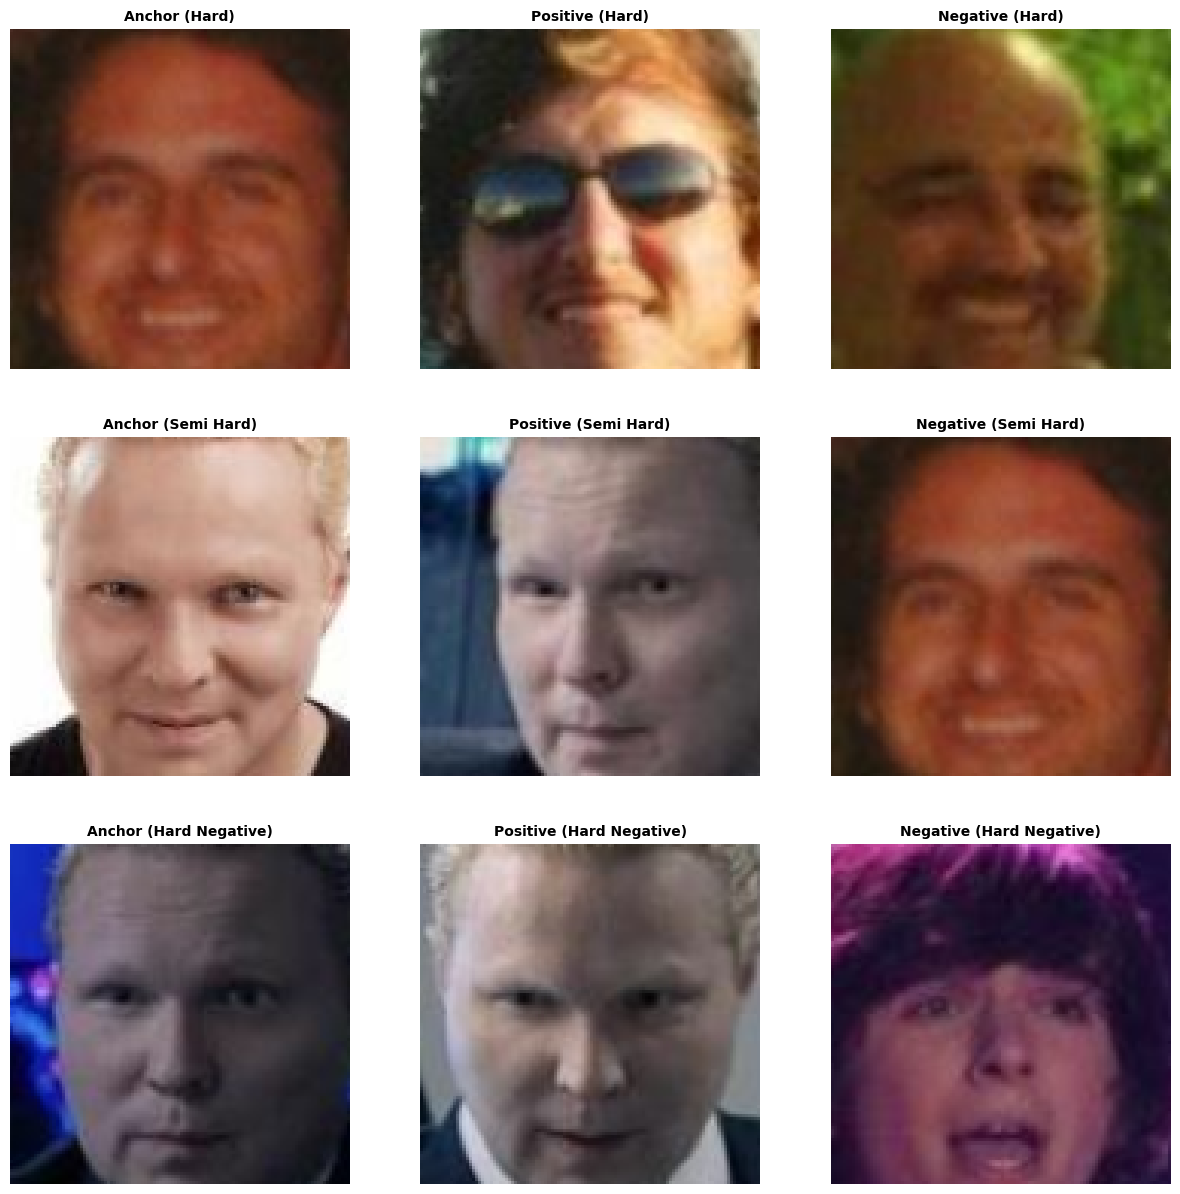

In [79]:
images = batch[1]

to_plot = (
keras.ops.take(images, indices=hard_sample[5], axis=0), keras.ops.take(images, indices=semi_hard_sample[5], axis=0),
keras.ops.take(images, indices=hard_negative_sample[5], axis=0))
labels = ['Hard', 'Semi Hard', 'Hard Negative']
version = ['Anchor', 'Positive', 'Negative']

# Visualise the sharpened image
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    current_set = to_plot[i]
    for j in range(3):
        axes[i, j].imshow(current_set[j, ...].numpy())
        axes[i, j].axis('off')
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        axes[i, j].set_title(f'{version[j]} ({labels[i]})', fontsize=10, color='black', weight='bold')

plt.show()


e) You should now write and execute a custom training loop to train your model. Your custom training loop should use the `circle_loss` and `get_triplets` functions defined in parts b) and c).

Your custom training loop should use a Keras optimizer to perform the gradient updates. It should also record performance metrics as the training progresses. It is advised to structure your training loop to regularly save your model during training.

Display the final loss and any other performance metrics for your best trained model.

**(6 marks)**

### Solutions 2e. Training the Models

Many of the design choices made here were inspired by the papers:

* Hermans, A., Beyer, L., & Leibe, B. (2017). In Defense of the Triplet Loss for Person Re-Identification. ArXiv, abs/1703.07737 
* Sun, Y., Cheng, C., Zhang, Y., Zhang, C., Zheng, L. and Wang, Z. (2020), "Circle Loss: A Unified Perspective of Pair Similarity Optimization," *IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Seattle, WA, USA*, 6397-6406

##### Comments on Triplet Selection
The suggested implementation is not optimal because the `get_triplets` function has to do a forward pass but it does not return the embeddings which means we need to do a second forward pass before we can compute the loss function. We have not used this implementation. Instead, we replaced the `get_triplets` function with a function that takes the embeddings and labels and returns the list of triplet indices. This ensures that we only have to do one forward pass over the batch data.

For the training data we tried `batch_hard`, `hard_negative` and `semi_negative` and ultimately found the best learning rate was achieved with `batch_hard`. `hard_negative` also achieved similar performance but required a lot longer to train.

In our training we have also used a validation set which consists of the same 32 identities and which provides a more consistent way of evaluating the training progress. For the validation set we do not use any mining, instead we use `batch_all` since we want to always have the same set of triplets.


##### Comments on Circle Loss
With regards to the circle loss, initially we tried using it with a fixed $\gamma$ and $m$, taken from the circle loss paper. However, after some expirementation, we found that we could achieve better results by having the parameters vary as the training progresses. In particular, we start with $\gamma=64$ and $m = 0.2$ and increase with the number of epochs.

**Motivation:**
 
 * $\gamma$ controls the weight placed on each triplet, based on its difficulty. Larger $\gamma$ makes the model focus on hard pairs because it adds more weight to the pairs that are positive and have low similarity or negative and have high similarity. Consequently, by increasing the value of $\gamma$ as the training progresses, we gradually increase the difficulty. Mathematically, larger $\gamma$ means steeper gradients.
* $m$ controls the decision boundary that separates the positive pairs from the negative pairs. If set to zero, there is no separation between positive and negative pairs. As it increases, the separation between the two clusters grows. We start with a small separation and gradually increase towards 1.


##### Comments on Learning Rate
For the learning rate we used an exponentially decaying schedule. As we tune $\gamma$ and $m$, and as the learning progresses, we want to dumpen the learning rate. Our exponential decay schedule allows us to control that. This schedule is an adaptation of the schedule used for the same task (but with a triplet loss function) in  Hermans, A., Beyer, L., & Leibe, B. (2017). In Defense of the Triplet Loss for Person Re-Identification. ArXiv, abs/1703.07737. The steps where the decay starts and stops, and the final factor, however, differ greatly from the paper and were chosen by studying the training loss of initial models which had no learning schedule, and observing where the loss function became too noisy and the learning halted.

##### Comments on Monitoring Metrics
We monitor the recall@1 and the average loss per batch. As explained above, the loss function used for training has increasing values of $\gamma$ and $\mu$. As a result, this is not a good metric to use for monitoring performance. However, due to the extra computational cost, we did not want to compute a second loss function with fixed parameters for each batch.

For the early stopping and model saving, we used the recall@1 on the validation data.

*Definition: Recall@k*

Given an image embedding, recall@k checks whether the true positive, i.e. the embedding of a photo of the same person, is found at least once in the top $k$ results returned by the model. In other words, out of the top $k$ most similar items, how often did the model find the correct one. Obviously, the larger the better.
Mathematically, for a single anchor embedding $x_a$:

$$
\text{Recall@k}(x_a) = \frac{ \text{No of positives (same person) in the top } k \text{ embeddings} }{\text{total number of positives} }
$$

where the top $k$ embeddings are those with the highest similarity to $x_a$. The recall@k for a batch is the average over all anchors in the batch.


##### Challenges and Lessons Learned
The biggest take-away is to avoid the use of `tensorflow` in the future for projects that require significant customisation. It was proven quite challenging to ensure compatibility with the `tf.function` decorator which maintaining sufficient flexibity.
Initially we tried progressively increasing the number of photos and the number of identities with training epochs. We also attempted to switch from semi-hard to hard negative and then to batch hard training, every time our model stopped improving for a number of epochs. We had to abandon both ideas due to the fact that `tf.function` creates a graph structure based on the initial inputs it receives the first time it is called. Attempting to change this signature, for example by changing the shape of the input batch, causes a graph retracing. There are possible remedies along the lines of specifying a signature for the wrapper function which allows for a dynamic tensor shape. However, this would not fix the issue with the changing signature of the triplet selection function. 


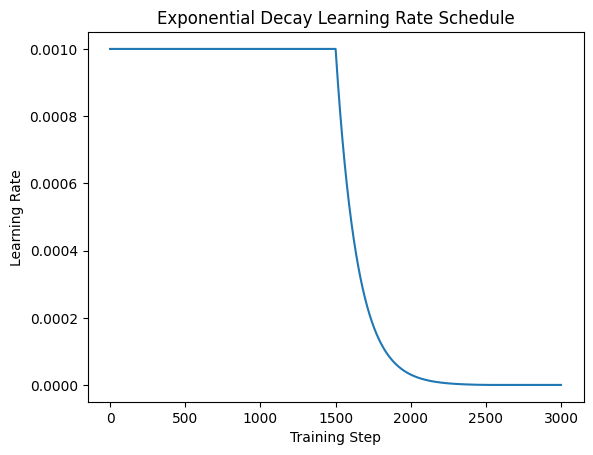

In [80]:
# This is adapted from the paper Hermans, A., Beyer, L., & Leibe, B. (2017). In Defense of the Triplet Loss for Person Re-Identification. ArXiv, abs/1703.07737.
class ExponentialDecaySchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr=1e-3, t0=15000, t1=25000, final_factor=0.001):
        super().__init__()
        self.initial_lr = initial_lr
        self.t0 = t0
        self.t1 = t1
        self.final_factor = final_factor

    def __call__(self, step):
        # Convert step to float for division ops
        step = tf.cast(step, tf.float32)

        # Phase 1: before t0, lr is constant
        phase1 = tf.less_equal(step, self.t0)
        lr_phase1 = self.initial_lr

        # Phase 2: t0 < step <= t1, exponential decay
        decay_exponent = (step - self.t0) / (self.t1 - self.t0)
        lr_phase2 = self.initial_lr * tf.pow(self.final_factor, decay_exponent)

        # Phase 3: after t1, lr stays at final value
        phase3 = tf.greater(step, self.t1)
        lr_phase3 = self.initial_lr * self.final_factor

        # Select learning rate based on current phase
        return tf.where(phase1, lr_phase1,
                        tf.where(phase3, lr_phase3, lr_phase2))


lr_schedule = ExponentialDecaySchedule(initial_lr=1e-3, t0=1500, t1=2500, final_factor=0.001)
optimiser = keras.optimizers.Adam(learning_rate=lr_schedule)

steps = keras.ops.arange(0, 3000, dtype='float32')
lrs = [lr_schedule(s).numpy() for s in steps]

plt.plot(steps, lrs)
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Decay Learning Rate Schedule")
plt.show()


In [81]:
# Helper functions

from IPython.display import clear_output

def plot(loss_values, title):
    clear_output()
    plt.figure(figsize=(8, 5))
    plt.plot(loss_values, label='Training loss', color='C0', linestyle='-')
    plt.xlabel('Batch Number')
    plt.ylabel('Training Loss')
    plt.title(title)
    plt.show()


def circle_loss_scheduled(epoch, anchor_embeddings, positive_embeddings, negative_embeddings,
                          base_m=0.2, base_gamma=64, step_size=5):
    '''
    TensorFlow-friendly helper function to dynamically update the parameters in the circle loss.
    '''
    # Cast constants as tensors for safety (optional, but recommended)
    base_m = tf.constant(base_m, dtype=tf.float32)
    base_gamma = tf.constant(base_gamma, dtype=tf.float32)
    step_size = tf.constant(step_size, dtype=tf.int32)

    # Compute increments using TensorFlow operations
    steps = tf.math.floordiv(epoch, step_size)

    # m = base_m + steps * 0.02
    m_increment = tf.multiply(tf.cast(steps, tf.float32), 0.02)
    m = tf.add(base_m, m_increment)
    m = tf.minimum(m, tf.constant(1.0, dtype=tf.float32))
    # gamma = base_gamma * (1 + steps * 0.5)
    gamma_increment = tf.multiply(tf.cast(steps, tf.float32), 0.5)
    gamma = tf.multiply(base_gamma, tf.add(1.0, gamma_increment))
    return circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings, m, gamma)


def recall_at_k(embeddings, labels, k=1):
    """
    Compute Recall@K. Use to monitor the training instead of the loss function
    """
    sims = keras.ops.matmul(embeddings, keras.ops.transpose(embeddings))
    sims = sims - keras.ops.eye(keras.ops.shape(sims)[0]) * 1e9  # Exclude self-similarity

    top_k = keras.ops.top_k(sims, k=k).indices
    labels = keras.ops.expand_dims(labels, axis=1)
    top_k_labels = keras.ops.take(labels, top_k)

    positive_matches = keras.ops.equal(top_k_labels, labels)
    recall = keras.ops.mean(keras.ops.any(positive_matches, axis=1), axis=0)
    return recall


@tf.function(reduce_retracing=True)
def training_step(batch, model, optimizer, epoch):
    with tf.GradientTape() as tape:
        batch_labels, batch_images = batch
        embeddings = model(batch_images, training=True)
        # if epoch < EPOCH_THRESHOLD:
        #     triplets = hard_negative(embeddings=embeddings, labels=batch_labels)
        # else:
        #     triplets = batch_hard(embeddings=embeddings, labels=batch_labels)
        triplets = batch_hard(embeddings, batch_labels)
        anchor_embeddings = keras.ops.take(embeddings, triplets[:, 0], axis=0)
        positive_embeddings = keras.ops.take(embeddings, triplets[:, 1], axis=0)
        negative_embeddings = keras.ops.take(embeddings, triplets[:, 2], axis=0)
        # loss = circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss = circle_loss_scheduled(epoch, anchor_embeddings, positive_embeddings, negative_embeddings)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, embeddings, batch_labels


@tf.function(reduce_retracing=True)
def validation_step(batch, model):
    batch_labels, batch_images = batch
    embeddings = model(batch_images, training=False)
    triplets = batch_all(embeddings=embeddings, labels=batch_labels)
    anchor_embeddings = keras.ops.take(embeddings, triplets[:, 0], axis=0)
    positive_embeddings = keras.ops.take(embeddings, triplets[:, 1], axis=0)
    negative_embeddings = keras.ops.take(embeddings, triplets[:, 2], axis=0)

    loss = circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
    recall = recall_at_k(embeddings, batch_labels, k=1)
    return loss, recall


def get_path(name, directory, fmt, postfix = '', overwrite: bool = True, mkdir: bool = True):
    path = Path(f'./{directory}/{name}{postfix}.{fmt}')
    if path.exists() and not overwrite:
        if postfix != '': postfix += 1
        else: postfix = 0
        return get_path(name=name, directory=directory, fmt=fmt, postfix=postfix)
    if mkdir:
        path.parent.mkdir(exist_ok=True, parents=True)
    return path


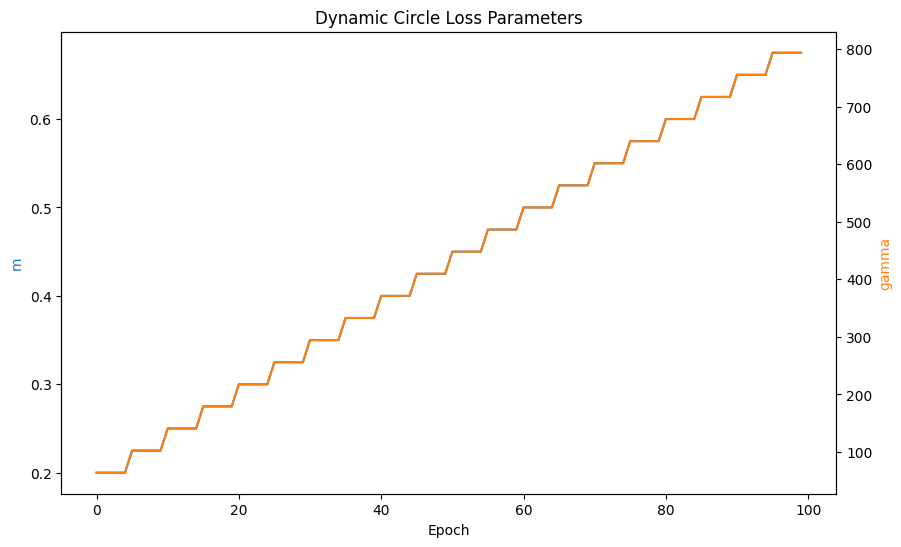

In [82]:
# Configure values for the circle schedule
base_m = 0.2
base_gamma = 64
step_size = 5
epochs = 100

m_values = []
gamma_values = []
for epoch in range(epochs):
    steps = epoch // step_size
    m_increment = steps * 0.025
    m = base_m + m_increment
    m = min(m, 1.0)
    gamma_increment = steps * 0.6
    gamma = base_gamma * (1 + gamma_increment)
    m_values.append(m)
    gamma_values.append(gamma)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(range(epochs), m_values, color='C0', label='m')
ax2.plot(range(epochs), gamma_values, color='C1', label='gamma')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('m', color='C0')
ax2.set_ylabel('gamma', color='C1')
plt.title('Dynamic Circle Loss Parameters')
plt.show()


In [83]:
# ---------------------------------- TRAINING FUNCTION -----------------------------------------
import time

# Common parameters:
# no_people = 50
# no_photos = 10
no_people = 32
no_photos = 5
epochs = 100
patience = 10
batch_length = (8000 - 32) // no_people # all IDs - 32 we hold for the validation data divided by the number of "batches" which have


def train(model, name):
    print(f'\n\n---------------------Training {name}---------------------')
    log_path = get_path(name=name, directory='logs', fmt='csv')
    chkpt_path_best = get_path(name=f'{name}_best', directory='models', fmt='weights.h5')
    chkpt_path_final = get_path(name=f'{name}_final', directory='models', fmt='weights.h5')
    val_batch = next(iter(get_dataloader(shuffle=False, augment=False)))

    # start at epoch 10 and decay until epoch 30
    lr_schedule = ExponentialDecaySchedule(initial_lr=1e-3, t0=int(batch_length*10), t1=int(batch_length*30), final_factor=0.001)
    optimiser = keras.optimizers.Adam(learning_rate=lr_schedule)

    step = 0
    patience_counter = 0
    best_recall_at_1 = 0.0

    losses = []
    recalls = []
    epoch_val_recall = []
    epoch_val_loss = []
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        train_dataloader = get_dataloader(no_people=no_people, no_photos=no_photos, shuffle=True, augment=True)

        epoch_losses = []
        epoch_recalls = []

        minibatch_losses = []
        minibatch_recalls = []

        for i, batch in enumerate(train_dataloader):
            step += 1
            epoch_tensor = tf.convert_to_tensor(epoch, dtype=tf.int32)
            loss_value, embeddings, labels = training_step(epoch=epoch_tensor,
                                                           batch=batch, model=model, optimizer=optimiser)
            recall_value = recall_at_k(embeddings, labels, k=1)
            loss_value, recall_value = keras.ops.convert_to_numpy(loss_value), keras.ops.convert_to_numpy(recall_value)

            minibatch_losses.append(loss_value)
            minibatch_recalls.append(recall_value)
            epoch_losses.append(loss_value)
            epoch_recalls.append(recall_value)
            losses.append(loss_value)
            recalls.append(recall_value)

            if i % 20 == 0:
                elapsed = time.time() - start_time
                elapsed = time.strftime('%H:%M:%S', time.gmtime(elapsed))

                running_loss = np.mean(minibatch_losses)
                running_recall = np.mean(minibatch_recalls)

                print(
                    f'\t[{epoch}: {i + 1}/{len(train_dataloader)} {elapsed}] Minibatch Loss: {running_loss:.4f}, Minibatch Recall@1: {running_recall:.4f}')
                minibatch_losses = []
                minibatch_recalls = []

        val_loss, val_recall = validation_step(val_batch, model)
        epoch_val_loss.append(keras.ops.convert_to_numpy(val_loss))
        epoch_val_recall.append(keras.ops.convert_to_numpy(val_recall))
        epoch_array = np.repeat(np.arange(1, 1 + epoch), batch_length)

        df = pd.DataFrame(dict(epoch=epoch_array, training_losses=losses,
                               training_recalls=recalls,
                               validation_loss_epoch_end=np.repeat(epoch_val_loss, batch_length),
                               validation_recall_epoch_end=np.repeat(epoch_val_recall, batch_length)))

        df.to_csv(log_path, index=False)
        # fig = plt.figure(figsize=(14, 10))
        # plt.plot(df.training_recalls, linewidth=1, color='C0', label='Recall')
        # plt.plot(df.training_losses, linewidth=1, color='C1', label='Circle Loss')
        # plt.title(f'{name}')
        # plt.legend()
        # fig.savefig(get_path(name=name, directory='plots', fmt='png').as_posix())
        # plt.close(fig)

        print(f'\tValidation Recall@1: {keras.ops.convert_to_numpy(val_recall):.4f}, Validation Loss: {keras.ops.convert_to_numpy(val_loss):.4f}')

        if val_recall > best_recall_at_1:
            best_recall_at_1 = val_recall
            patience_counter = 0
            print(f'\t[{epoch}/{epochs}] New Best Recall@1: {keras.ops.convert_to_numpy(best_recall_at_1):.4f}. Saving model...')
            model.save_weights(chkpt_path_best, overwrite=True)
            if time.time() - start_time > 1 * 60 * 60: # Force early stopping after 1 hour(s)
                print(f'\t[{epoch}/{epochs}] Early stopping triggered after 2 hours.')
                model.save_weights(chkpt_path_final, overwrite=True)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\t[{epoch}/{epochs}] Early stopping triggered after {patience_counter} epochs without improvement.')
                model.save_weights(chkpt_path_final, overwrite=True)
                break
        if time.time() - start_time > 1.5 * 60 * 60: # Force early stopping after 1.5 hour(s)
            print(f'\t[{epoch}/{epochs}] Early stopping triggered after 2 hours.')
            model.save_weights(chkpt_path_final, overwrite=True)
            break
    print('---------Training Completed------------')


    df = pd.DataFrame(dict(losses=losses, recalls=recalls))
    df.to_csv(log_path, index=False)
    # fig = plt.figure(figsize=(14, 10))
    # plt.plot(df.recalls, linewidth=1, color='C0', label='Recall')
    # plt.plot(df.losses, linewidth=1, color='C1', label='Circle Loss')
    # plt.title(f'{chkpt_path.name}')
    # plt.legend()
    # fig.savefig(get_path(name=name, directory='plots', fmt='png').as_posix())

#### Training Example

We trained our models using the above code and the functions below. This was not done in a notebook, instead we wrote python scripts.
The full code (which is identical to what is here but split into modules) can be found in [this git repo](https://github.com/ariana-ch/cw1/) which is currently public. The repo also contains the weights of the trained models and training logs.

Here we provide the functions we used to train each model and demonstrating its use for `SimpleEmbeddingNetV2` with 6 convolutional blocks and a flatten layer (instead of a global pooling layer) to flatten the images before the fully connected layer. We had to kill the training after 7 hours but all results up to that point were stored and we could use the model trained up to that point.

For all our models we used a 128 dimensional embedding. This was motivated by all the literature we read, relating to image embeddings that seek to create clusters of images of the same identities.

**If you wish to test the code for a different model, you must first re-run the cell where the `train_step` and `validation_step` are defined because `tensorflow` traces those functions and expects the same signature everytime.**

In [156]:
MODEL_GETTERS = []

def train_simple_embedding_5_flat_top():
    model = SimpleEmbeddingNet(top='flatten', no_blocks=5)
    name = 'SimpleEmbeddingNet5_FlattenTop'
    train(model=model, name=name)

def get_simple_embedding_5_flat_top(best: bool = True):
    version = 'best' if best else 'final'
    model = SimpleEmbeddingNet(top='flatten', no_blocks=5)
    name = 'SimpleEmbeddingNet5_FlattenTop'
    name = f'{name}_{version}'
    path = get_path(name=name, directory='models', fmt='weights.h5', mkdir=False)
    model.load_weights(path)
    return name, model
MODEL_GETTERS.append(get_simple_embedding_5_flat_top)

def train_simple_embedding_5_pooling_top():
    model = SimpleEmbeddingNet(top='pooling', no_blocks=5)
    name = 'SimpleEmbeddingNet5_PoolingTop'
    train(model=model, name=name)

def get_simple_embedding_5_pooling_top(best: bool = True):
    version = 'best' if best else 'final'
    model = SimpleEmbeddingNet(top='pooling', no_blocks=5)
    name = 'SimpleEmbeddingNet5_PoolingTop'
    name = f'{name}_{version}'
    path = get_path(name=name, directory='models', fmt='weights.h5', mkdir=False)
    model.load_weights(path)
    return name, model
MODEL_GETTERS.append(get_simple_embedding_5_pooling_top)


def train_simple_embedding_4_pooling_top_avg_pooling():
    # Worse - no improvement and slow training despite the smaller model
    model = SimpleEmbeddingNet(top='pooling', no_blocks=4, pooling='avg')
    name = 'SimpleEmbeddingNet4_PoolingTop_AvgPooling'
    train(model=model, name=name)

def get_simple_embedding_4_pooling_top_avg_pooling(best: bool = True):
    # Worse - no improvement and slow training despite the smaller model
    version = 'best' if best else 'final'
    model = SimpleEmbeddingNet(top='pooling', no_blocks=4, pooling='avg')
    name = 'SimpleEmbeddingNet4_PoolingTop_AvgPooling'
    name = f'{name}_{version}'
    path = get_path(name=name, directory='models', fmt='weights.h5', mkdir=False)
    model.load_weights(path)
    return name, model

def train_simple_embeddingV2_5_flat_top():
    model = SimpleEmbeddingNetV2(top='flatten', no_blocks=5)
    name = 'SimpleEmbeddingNetV2_5_FlattenTop'
    train(model=model, name=name)

def get_simple_embeddingV2_5_flat_top(best: bool = True):
    version = 'best' if best else 'final'
    model = SimpleEmbeddingNetV2(top='flatten', no_blocks=5)
    name = 'SimpleEmbeddingNetV2_5_FlattenTop'
    name = f'{name}_{version}'
    path = get_path(name=name, directory='models', fmt='weights.h5', mkdir=False)
    model.load_weights(path)
    return name, model
# MODEL_GETTERS.append(get_simple_embeddingV2_5_flat_top)

def train_simple_embeddingV2_6_flat_top():
    model = SimpleEmbeddingNetV2(top='flatten', no_blocks=6)
    name = 'SimpleEmbeddingNetV2_6_FlattenTop'
    train(model=model, name=name)

def get_simple_embeddingV2_6_flat_top(best: bool = True):
    version = 'best' if best else 'final'
    model = SimpleEmbeddingNetV2(top='flatten', no_blocks=6)
    name = 'SimpleEmbeddingNetV2_6_FlattenTop'
    name = f'{name}_{version}'
    path = get_path(name=name, directory='models', fmt='weights.h5', mkdir=False)
    model.load_weights(path)
    return name, model
MODEL_GETTERS.append(get_simple_embeddingV2_6_flat_top)

def train_simple_embeddingV2_5_pooling_top():
    model = SimpleEmbeddingNetV2(top='pooling', no_blocks=5)
    name = 'SimpleEmbeddingNetV2_5_PoolingTop'
    train(model=model, name=name)

def get_simple_embeddingV2_5_pooling_top(best: bool = True):
    version = 'best' if best else 'final'
    model = SimpleEmbeddingNetV2(top='pooling', no_blocks=5)
    name = 'SimpleEmbeddingNetV2_5_PoolingTop'
    name = f'{name}_{version}'
    path = get_path(name=name, directory='models', fmt='weights.h5', mkdir=False)
    model.load_weights(path)
    return name, model
MODEL_GETTERS.append(get_simple_embeddingV2_5_pooling_top)

def train_efficient_net():
    # Very bad performance - needs more data/training?
    model = EfficientNet((112, 112, 3), activation='swish')
    name = 'EfficientNet'
    train(model=model, name=name)

def get_efficient_net(best: bool = True):
    version = 'best' if best else 'final'
    # Very bad performance - needs more data/training?
    model = EfficientNet((112, 112, 3), activation='swish')
    name = 'EfficientNet'
    name = f'{name}_{version}'
    path = get_path(name=name, directory='models', fmt='weights.h5', mkdir=False)
    model.load_weights(path)
    return name, model

def train_efficient_net_pretrained():
    model = EfficientNetPretrained((112, 112, 3), freeze_weights=True)
    name = 'EfficientNetPretrained'
    train(model=model, name=name)

def get_efficient_net_pretrained(best: bool = True):
    version = 'best' if best else 'final'
    model = EfficientNetPretrained((112, 112, 3), freeze_weights=True)
    name = 'EfficientNetPretrained'
    name = f'{name}_{version}'
    path = get_path(name=name, directory='models', fmt='weights.h5', mkdir=False)
    model.load_weights(path)
    return name, model

In [130]:
# train_simple_embeddingV2_6_flat_top()



---------------------Training SimpleEmbeddingNetV2_6_FlattenTop---------------------

Epoch 1/100
	[1: 1/159 00:00:09] Minibatch Loss: 0.6764, Minibatch Recall@1: 0.0800
	[1: 21/159 00:00:54] Minibatch Loss: 0.6333, Minibatch Recall@1: 0.1092
	[1: 41/159 00:01:38] Minibatch Loss: 0.5855, Minibatch Recall@1: 0.1263
	[1: 61/159 00:02:21] Minibatch Loss: 0.5811, Minibatch Recall@1: 0.1378
	[1: 81/159 00:03:03] Minibatch Loss: 0.5776, Minibatch Recall@1: 0.1410
	[1: 101/159 00:03:45] Minibatch Loss: 0.5734, Minibatch Recall@1: 0.1522
	[1: 121/159 00:04:27] Minibatch Loss: 0.5742, Minibatch Recall@1: 0.1491
	[1: 141/159 00:05:10] Minibatch Loss: 0.5704, Minibatch Recall@1: 0.1699
	Validation Recall@1: 0.2969, Validation Loss: 0.4492
	[1/100] New Best Recall@1: 0.2969. Saving model...

Epoch 2/100
	[2: 1/159 00:05:56] Minibatch Loss: 0.5712, Minibatch Recall@1: 0.1700
	[2: 21/159 00:06:38] Minibatch Loss: 0.5681, Minibatch Recall@1: 0.1756
	[2: 41/159 00:07:20] Minibatch Loss: 0.5676, Mini

KeyboardInterrupt: 

#### Perfomance Comparison

Below we display plots of the models along with the loss and recall@1 values, during training. These values are on the training dataset. The only reason we used the test dataset was because it allowed us to have a more consistent comparison across epochs.

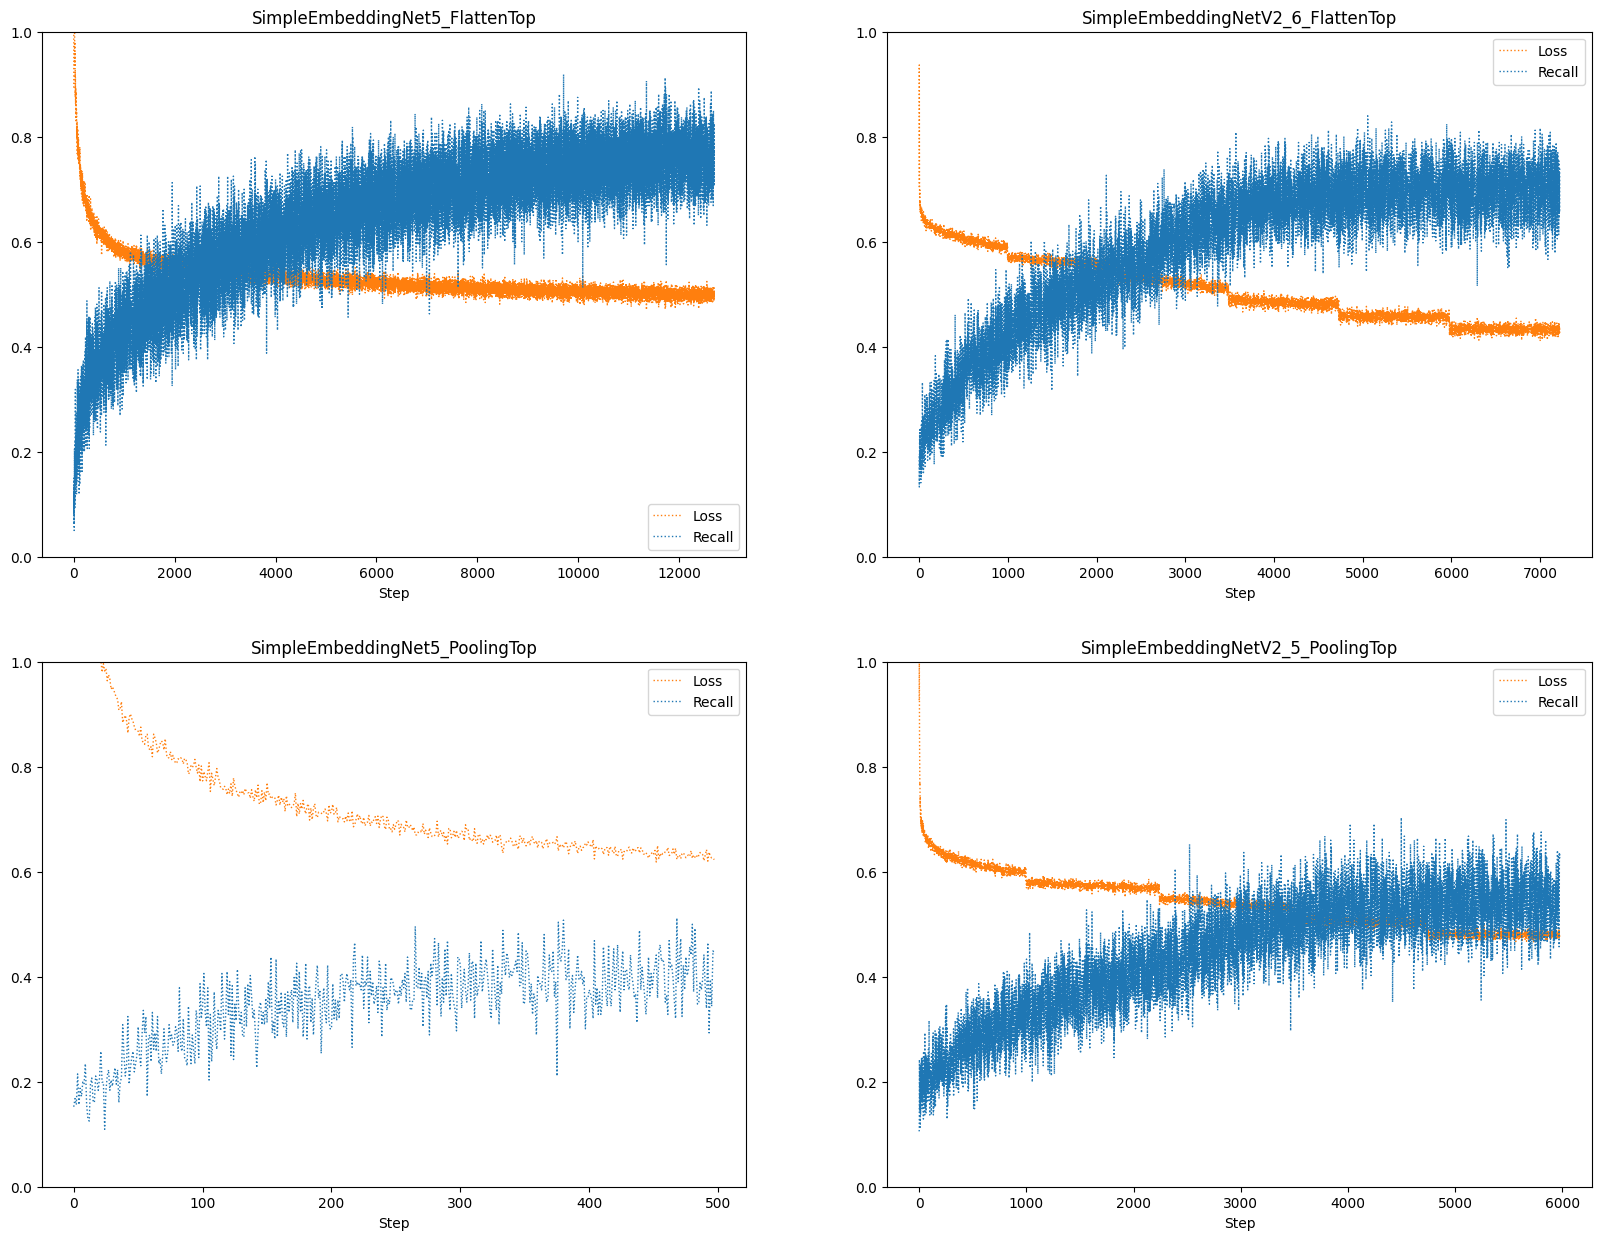

In [215]:
# Visualise the sharpened image
# MODEL_GETTERS = [get_simple_embedding_5_flat_top, get_simple_embedding_5_pooling_top, get_simple_embeddingV2_6_flat_top, get_simple_embeddingV2_5_pooling_top]
fig, axes = plt.subplots(len(MODEL_GETTERS)//2 + int(bool(len(MODEL_GETTERS) % 2)), 2,
                         figsize=(20, 15))

for i, entry in enumerate(MODEL_GETTERS):
    name, model = entry(best=True)
    name = name.rsplit('_', 1)[0]
    df = pd.read_csv(get_path(name, 'logs', fmt='csv', mkdir=False))
    axes[i % 2, i // 2].plot(df.training_losses, linewidth=1, color='C1', label='Loss', linestyle='dotted')
    axes[i % 2, i // 2].plot(df.training_recalls, linewidth=1, color='C0', label='Recall', linestyle='dotted')
    # axes[i % 2, i // 2].plot(df.validation_loss_epoch_end, linewidth=1, color='C1', label='Val Loss Epoch End')
    # axes[i % 2, i // 2].plot(df.validation_recall_epoch_end, linewidth=1, color='C0', label='Val Recall Epoch End')
    axes[i % 2, i // 2].set_xlabel('Step')
    axes[i % 2, i // 2].set_title(f'{name}')# (Best Val Recall {df.validation_recall_epoch_end.values[-1]})', fontsize=10)
    axes[i % 2, i // 2].set_ylim([0, 1])
    axes[i % 2, i // 2].legend()
plt.show()


In [ ]:
logs = []
for (name, _) in MODEL_GETTERS:
    df = pd.read_csv(get_path(name, directory='logs', fmt='csv', mkdir=False, overwrite=True))
    df['model'] = name.rsplit('_', 1)[0]
    logs.append(df)

logs = pd.concat(logs, axis='rows')
logs.groupby('model', 'epoch').mean()


#### Question 3 (Total 7 marks)

In this question you will view your trained model as a binary classifier that predicts whether two images are the same person or not. You will test your trained model on a subset of the Labeled Faces in the Wild (LFW) dataset. This dataset also consists of a number of identities, and a number of images per identity. It was introduced in the following paper:

* Huang, G.B., Ramesh, M., Berg, T., and Learned-Miller, E. (2007), "Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments", University of Massachusetts, Amherst, Technical Report 07-49.

The subset is available for you in the folder `./data/labeled-faces-in-the-wild`.  There is also the file `lfw_test_pairs.txt` in the `./data` folder that you will use for testing. This file lists a number of pairs of images in the LFW dataset that either belong to the same identity or different identities.

_NB: if you have not been able to successfully train a model in question 2, you can still complete all of question 3 using any Keras model that takes images as input and returns embeddings. The results may not be good, but you can still demonstrate the methodology and implementation for testing the model._

a) You will now use your best model from question 2 to compute predictions on the LFW subset to say whether or not two images are the same person. 

Apply any appropriate data preprocessing to the images, and compute model embeddings and similarity scores for all images in the test data.

Display a histogram with the distribution of positive and negative similarity scores from your model.

**(4 marks)**

### Solutions 3a. Labeled Faces In The Wild Re-Identification

For this exercise we created a torch dataset for our own convenience. In trying to determine a suitable batch size, we observed that embedding Image 1 and Image 2 separately and embedding a concatenation of the two into a batch of size 2, gives slightly different embeddings (8th decimal place of each component of the resulting vector is different). Although this is small, it had initially motivated us to try and load batch sizes equal to 1, i.e. one pair of images at a time. Unfortunately, we found that this was very slow as we had to perform 120,000 predictions.
Instead, we ended up loading all images in one batch of size (6000, 2, 112, 112, 3).

The images were prepropsed to ensure that they have the expected input format, in line with what was used during training. Additionally, we attempted to create a 5 crop of each image (similar to what is done for test images in *Hermans et al. (2017)*), embed each of the 5 crops and then average the resulting embeddings. Unfortunately, this approach was abandoned as it led to worse results.

In [98]:
from typing import List

# --- Helper Functions ---
def get_lfiw_paths() -> List[tuple]:
    '''
    Helper function to get a list of tuples with (image_path1, image_path2, label)
    where label = 1 if it's the same person and 0 if it's a different person
    Returns:

    '''
    file = Path('./data/lfw_test_pairs.txt')
    img_dir = Path('./data/labeled-faces-in-the-wild')
    paths = []
    with open(file, 'r') as f:
        for line in f:
            line = line.strip().split()
            if len(line) == 3:
                person = line[0]
                photos = [f"{person}_{'0' * (4 - len(x))}{x}.jpg" for x in line[1:]]
                paths.append((os.path.join(img_dir, person, photos[0]),
                              os.path.join(img_dir, person, photos[1]),
                              1))
            elif len(line) == 4:
                person1, person2 = line[0], line[2]
                photos = [f"{person1}_{'0' * (4 - len(line[1]))}{line[1]}.jpg",
                          f"{person2}_{'0' * (4 - len(line[3]))}{line[3]}.jpg"]
                paths.append((os.path.join(img_dir, person1, photos[0]),
                              os.path.join(img_dir, person2, photos[1]),
                              0))
    return paths


class LFIWDataset(torch.utils.data.Dataset):
    def __init__(self, paths: list, five_crop: bool=False):
        '''
        Load the Faces in the wild into a dataset
        Args:
            paths: list of tuples with (image_path, image_path, label) where label is 1 if it's the same person and 0 if it's a different person
            five_crop: Each image is cropped five times and each "sub-image" is returned. This allows for ensembling (from the paper Hermans, A., Beyer, L., & Leibe, B. (2017). In Defense of the Triplet Loss for Person

        '''
        self.paths = paths
        self.default_transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.ConvertImageDtype(torch.float32),
                                              transforms.Resize((128, 128)),
                                              transforms.CenterCrop((112, 112))])

        self.five_crop_transforms = transforms.Compose([
            transforms.Resize((132, 132)),
            transforms.FiveCrop(112),
            transforms.Lambda(lambda crops: torch.stack([
                transforms.Compose([
                    transforms.ToTensor(),
                    transforms.ConvertImageDtype(torch.float32),
                ])(crop) for crop in crops
            ]))
        ])
        self.transforms = self.default_transforms if not five_crop else self.five_crop_transforms
        self.reshape = (0, 1, 3, 4, 2) if five_crop else (0, 2, 3, 1)


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        item = self.paths[idx]
        img_paths, label = item[:2], item[2]

        img_list = []
        for img_path in img_paths:
            img = Image.open(img_path)  # already in RGB here.
            img_tensor = self.transforms(img)
            img_list.append(img_tensor)

        img_tensor = torch.stack(img_list, dim=0)  # shape N, C, H, W
        img_tensor = img_tensor.permute(*self.reshape)
        label_tensor = torch.tensor(label).unsqueeze(0)
        return label_tensor, img_tensor

def collate_fn(batch):
    labels, images = zip(*batch)
    labels = torch.cat(labels, dim=0)
    images = torch.cat(images, dim=0)
    return labels, images


def LFIWDataloader(paths: list, five_crop: bool=False, batch_size = 6000):
    '''
        Function to get the dataloader for the LFIW dataset
    '''
    dataset = LFIWDataset(paths, five_crop=five_crop)
    if batch_size == 1:
        return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, drop_last=False, collate_fn=collate_fn)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=None)

# lfw_dl_5crop = LFIWDataloader(paths=get_lfw_paths(), five_crop=True)
lfiw_dl = LFIWDataloader(paths=get_lfiw_paths(), five_crop=False)

pd.DataFrame(get_lfiw_paths(), columns=['Image1', 'Image2', 'Label']).groupby('Label').apply('count')

,Image1,Image2
Label,,
0,3000,3000
1,3000,3000


In [127]:
def get_lfiw_cosine_similarities(model: keras.Model, dataloader: torch.utils.data.dataloader.DataLoader=None,
                                 batch: tuple=None) -> pd.DataFrame:
    '''
    Function to get the cosine similarities for the LFW dataset
    
    :param model: The model to use for the embeddings
    :param data: The dataloader for the LFW dataset. This should have (batch, 2, 112, 112, 3) shape
    :param batch: Instead of passing the dataloader which means reloading all images from disk, can also pass the batch with 6000 image pairs and the labels.
    '''
    res = []
    data = [batch] if batch else dataloader
    for (labels, images) in iter(data):
        shape = images.shape[0:2]
        images = images.flatten().reshape(shape[0] * shape[1], 112, 112, 3)
        embedding = model.predict(images)
        embedding = embedding.reshape(shape[0], shape[1], 128)
        similarities = scaled_cosine_similarity(embedding[:, 0, :], embedding[:, 1, :])
        res.extend(list(zip(*[labels.squeeze().numpy(), similarities.numpy()])))
    df = pd.DataFrame(data=res, columns = ['label', 'cos_similarity'])
    return df

In [100]:
def plot_lfiw_cosine_similarities(df, model_name):
    plt.hist(df[df.label==1].cos_similarity, label='Same', alpha=0.5, bins=100)
    plt.hist(df[df.label==0].cos_similarity, label='Different', alpha=0.5, bins=100)
    plt.legend()
    plt.title(model_name, fontdict=dict(size=10))
    plt.show()


In [180]:
batch = next(iter(lfiw_dl))



375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


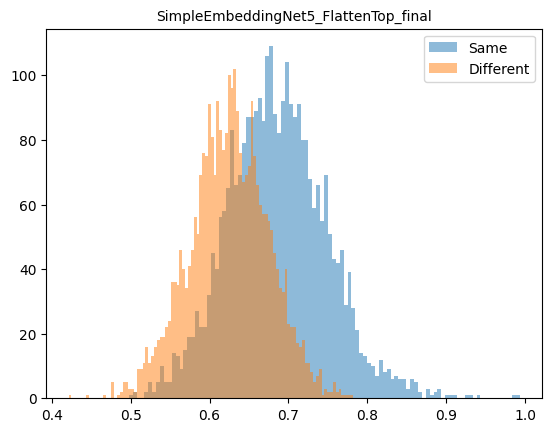

In [211]:
# name, model = get_simple_embedding_5_flat_top(False)
# model.load_weights('models_backup/SimpleEmbeddingNetV2_6_FlattenTop.weights.h5')
# batch = next(iter(lfiw_dl))
name, model = get_simple_embedding_5_flat_top(False)
# model.load_weights('models_backup/SimpleEmbeddingNetV2_6_FlattenTop.weights.h5')
df = get_lfiw_cosine_similarities(model=model, dataloader=None, batch=batch)
plot_lfiw_cosine_similarities(df, name)

In [212]:
df.groupby(['label']).describe().T.round(3)

label                        0         1
cos_similarity count  3000.000  3000.000
               mean      0.625     0.686
               std       0.050     0.063
               min       0.421     0.498
               25%       0.593     0.644
               50%       0.626     0.684
               75%       0.658     0.726
               max       0.782     0.993

b) Use the computed similarity scores from part a) to calculate the area under the ROC curve and the area under the precision-recall (PR) curve for your classifier model. Use the Keras `AUC` metric (see [the docs](https://keras.io/api/metrics/classification_metrics/#auc-class)) to do this.

Compute the threshold that maximises the accuracy of your classifier on the LFW test data. Plot the accuracy as a function of the threshold, and report the optimal threshold and resulting accuracy.

**(3 marks)**

### Solutions 3c. Model Evaluation and Use for Re-Identification

**Definition: ROC AUC**:
The ROC AUC (Receiver Operating Characteristic - Area Under the Curve) measures the ability of a binary classifier to distinguish between two classes (positive and negative) across all possible classification thresholds.

It is the area under the Receiver Operating Characteristic (ROC) curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at varying thresholds.
Mathematically,
$$
TPR = \frac{TP}{TP + FN}, \qquad
FPR = \frac{FP}{FP + TN}
$$
$$
ROC\ AUC = \int_{0}^{1} TPR(FPR^{-1}(x))\ dx
$$

The closer to 1, the better the classifier with 0.5 corresponding to random classification.


**Definition: PR AUC **:
The PR AUC (Precision-Recall Area Under the Curve) measures the trade-off between Precision (Positive Predictive Value) and Recall (True Positive Rate) for different thresholds.
It is the area under the Precision-Recall (PR) curve, which plots Precision versus Recall at varying thresholds.
Mathematically,
$$
\text{Precision} = \frac{TP}{TP + FP}, \qquad \text{Recall} = \frac{TP}{TP + FN}
$$
and
$$
PR\ AUC = \int_{0}^{1} \text{Precision}(\text{Recall}^{-1}(x))\ dx
$$

PR AUC is especially informative for imbalanced datasets, where positive examples are rare.
$PR\ AUC = 1.0$ implies perfect precision and recall across all thresholds.


**Optimal Threshold (for maximising accuracy)**:

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

   * Create a grid of thresholds and compute the accuracy at each threshold
   * Use the grid data to determine the threshold for the maximum accuracy
   * Use the grid data for plotting

In [213]:

y_true = df['label'].values
y_scores = df['cos_similarity'].values

# ROC AUC
roc_auc = keras.metrics.AUC(curve='ROC')
roc_auc.update_state(y_true, y_scores)
roc_auc_value = roc_auc.result().numpy()

# PR AUC
pr_auc = keras.metrics.AUC(curve='PR')
pr_auc.update_state(y_true, y_scores)
pr_auc_value = pr_auc.result().numpy()

print(f'ROC AUC: {roc_auc_value:.4f}')
print(f'PR AUC: {pr_auc_value:.4f}')


ROC AUC: 0.7792
PR AUC: 0.7987


In [214]:
thresholds = np.linspace(0, 1, 1000)
accuracies = []

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    acc = np.mean(y_pred == y_true)
    accuracies.append(acc)

accuracies = np.array(accuracies)
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
best_accuracy = accuracies[best_idx]

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best Accuracy: {best_accuracy:.4f}')


Best Threshold: 0.6607
Best Accuracy: 0.7088


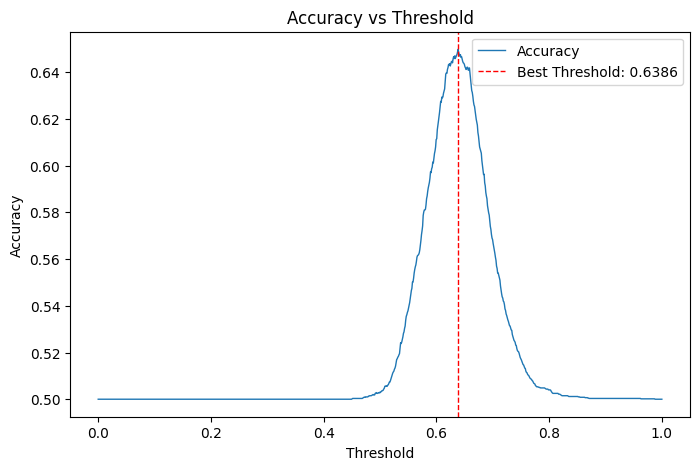

In [206]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, label='Accuracy', linewidth=1)
plt.axvline(best_threshold, color='r', linestyle='--', linewidth=1, label=f'Best Threshold: {best_threshold:.4f}')
plt.title('Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### Question 4 (Total 10 marks)

Provide a separate PDF report with an account of the experiments you have run in question 2. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices. 

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time? What do you think are the most promising directions for performance gains?

Marks will be awarded for presentation and clarity. Your report should be no more than 3 pages, excluding references.

**(10 marks)**